In [1]:
import sys
import os
import subprocess

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
#import time
#from scipy.optimize import minimize
#from sklearn.linear_model import LinearRegression
#import glob
#import datetime
#import scipy
#from scipy.sparse import diags
from functools import reduce

#from scipy.linalg import solve_banded
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker


#from sklearn.metrics import mean_squared_error



current_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_dir, '..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)

from SCOU_NC_LoQ_NUTS import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def notify_mac(title, message):
    script = f'display notification "{message}" with title "{title}"'
    subprocess.run(['osascript', '-e', script])

In [3]:
filepath = '../data/Données HPV V2.xlsx'

data_HPV_HF = pd.read_excel(filepath, sheet_name='Hautes fréquences')
data_HPV_HF = data_HPV_HF.iloc[:, [1, -3, -8, 5]]
data_HPV_HF = data_HPV_HF.loc[1:]
data_HPV_HF.columns = ['dateStart', 'obs_HPV', 'obs_crAssphages', 'inhibition']

# Manual inputs for dateStart
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('03/07/2024', '2024-07-03')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('01/09/2024', '2024-09-01')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('04/09/2024', '2024-09-04')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('10/08/2024', '2024-08-10')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('14/08/2024', '2024-08-14')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('25/08/2024', '2024-08-25')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('03/11/2024', '2024-11-03')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('06/11/2024', '2024-11-06')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('10/11/2024', '2024-11-10')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('01/12/2024', '2024-12-01')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('04/12/2024', '2024-12-04')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('08/12/2024', '2024-12-08')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('05/01/2025', '2025-01-05')




data_HPV_HF.dateStart = pd.to_datetime(data_HPV_HF.dateStart)#, format='DD/MM/YYYY')
data_HPV_HF.obs_HPV = pd.to_numeric(data_HPV_HF.obs_HPV)
data_HPV_HF.obs_crAssphages = pd.to_numeric(data_HPV_HF.obs_crAssphages)
data_HPV_HF.inhibition = pd.to_numeric(data_HPV_HF.inhibition)
data_HPV_HF.sort_values(by='dateStart', inplace=True)
data_HPV_HF.head()

dateStart       obs_HPV  obs_crAssphages  inhibition
1 2024-01-24  18613.855375     2.663931e+07    0.778384
2 2024-01-28  32242.166419     5.253436e+07    0.515037
3 2024-01-31  33190.381878     3.806105e+07    0.479286
4 2024-02-04  64956.400453     2.717509e+07    0.000000
5 2024-02-07  51089.113535     2.478178e+07    0.000000

In [4]:
data_HPV_HF.dateStart.value_counts().head()
data_HPV_HF.drop_duplicates(subset='dateStart', inplace=True)
data_HPV_HF.set_index('dateStart', inplace=True)

In [5]:
mapping_dict = {'janvier': '01', 'février': '02', 'mars': '03', 'avril': '04', 'mai': '05',
                              'juin':'06', 'juillet':'07', 'août':'08', 'septembre':'09', 'octobre':'10', 
                              'novembre':'11', 'décembre':'12'}

In [6]:
volumes_clichy = pd.read_excel("../data/Débit sur Clichy 2021 - 2024.xlsx", sheet_name="Données")
volumes_clichy = volumes_clichy.loc[1:]
volumes_clichy.columns = ['dateStart', 'plantVolume']

volumes_clichy_first_part = volumes_clichy.loc[:1095].copy()
volumes_clichy_second_part = volumes_clichy.loc[1096:].copy()
volumes_clichy_first_part.dateStart = pd.to_datetime(volumes_clichy_first_part.dateStart)

volumes_clichy_second_part['dateStart'] = volumes_clichy_second_part['dateStart'].apply(
    lambda x: reduce(lambda s, kv: s.replace(*kv), mapping_dict.items(), str(x)))

volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: x[:-2] + '2024')

volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: x.split(' ')[1:])

volumes_clichy_second_part.dateStart.apply(lambda x: x.reverse())
volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: '-'.join(x))
volumes_clichy_second_part.dateStart = pd.to_datetime(volumes_clichy_second_part.dateStart)

volumes_clichy.dateStart = volumes_clichy_first_part.dateStart.tolist() + volumes_clichy_second_part.dateStart.tolist()

volumes_clichy.plantVolume = pd.to_numeric(volumes_clichy.plantVolume)


volumes_clichy.set_index('dateStart', inplace=True)

data_HPV_HF = data_HPV_HF.join(volumes_clichy['plantVolume'])
data_HPV_HF.reset_index(inplace=True)

In [7]:
remaining_volumes = pd.read_excel(filepath, sheet_name='Données débits manquants')
remaining_volumes = remaining_volumes.iloc[:, [0, 2]]
remaining_volumes = remaining_volumes.loc[3:]
remaining_volumes.columns = ['dateStart', 'plantVolume']
remaining_volumes.loc[3, 'dateStart'] = 'lundi 1 décembre 2024'

remaining_volumes.dateStart = remaining_volumes.dateStart.apply(lambda x: str(x).replace('décembre', '12').replace('janvier', '01').replace('février', '02').split(' ')[1:])
remaining_volumes.dateStart.apply(lambda x: x.reverse())
remaining_volumes.dateStart = remaining_volumes.dateStart.apply(lambda x: '-'.join(x))
remaining_volumes.dateStart = pd.to_datetime(remaining_volumes.dateStart)

In [8]:
remaining_volumes.set_index('dateStart', inplace=True)
data_HPV_HF.set_index('dateStart', inplace=True)
data_HPV_HF['plantVolume'] = data_HPV_HF['plantVolume'].combine_first(remaining_volumes['plantVolume'])
data_HPV_HF.reset_index(inplace=True)

In [9]:
data_HPV_HF.plantVolume = 1000 * data_HPV_HF.plantVolume

In [10]:
data_HPV_HF['lod'] = 2000
data_HPV_HF['loq'] = 3000

In [11]:
# normalisation des obs HPV par les crAssphages pour 
# prendre en compte l'inhibition
# ainsi que le rendement d'extraction
data_HPV_HF['obs'] = data_HPV_HF['obs_HPV'].div(data_HPV_HF['obs_crAssphages'])
data_HPV_HF['lod'] = data_HPV_HF['lod'].div(data_HPV_HF['obs_crAssphages'])
data_HPV_HF['loq'] = data_HPV_HF['loq'].div(data_HPV_HF['obs_crAssphages'])

In [12]:
data_HPV_HF["obs_raw"] = data_HPV_HF.obs.copy()
data_HPV_HF["lod_raw"] = data_HPV_HF.lod.copy()
data_HPV_HF["loq_raw"] = data_HPV_HF.loq.copy()

data_HPV_HF.obs_raw = np.log(data_HPV_HF.obs_raw)
data_HPV_HF.lod_raw = np.log(data_HPV_HF.lod_raw)

data_HPV_HF.obs = np.log(data_HPV_HF.obs)
data_HPV_HF.lod = np.log(data_HPV_HF.lod)
data_HPV_HF.loq = np.log(data_HPV_HF.loq)

In [13]:
# Now we subsample
# We first need to keep track of the year-week combo

In [14]:
data_HPV_HF['year'] = data_HPV_HF.dateStart.dt.year
data_HPV_HF['month'] = data_HPV_HF.dateStart.dt.month
data_HPV_HF['week'] = data_HPV_HF.dateStart.dt.isocalendar().week

In [15]:
data_HPV_HF['year-week'] = data_HPV_HF['year'].astype(str) + '-' + data_HPV_HF['week'].astype(str)
data_HPV_HF['year-month'] = data_HPV_HF['year'].astype(str) + '-' + data_HPV_HF['month'].astype(str)

In [16]:
# on a deux échantillons par semaine
# on peut tester un par semaine en gardant soit le premier, soit le deuxieme

In [17]:
def get_monthly_subsamples(data_HPV_HF, index_position=6, remove_those=[]):

    subsampled_data_HPV_HF = data_HPV_HF.copy()
    subsampled_data_HPV_HF = subsampled_data_HPV_HF.loc[subsampled_data_HPV_HF['year-month']!='2024-1']

    second_samples = []
    for combination in subsampled_data_HPV_HF['year-month'].unique().tolist():
        temp_data = subsampled_data_HPV_HF.loc[subsampled_data_HPV_HF['year-month']==combination]
        second_samples.append(temp_data.index.tolist()[index_position])
        print(combination, temp_data.index.tolist())

    subsampled_data_HPV_HF = subsampled_data_HPV_HF.loc[second_samples]
    subsampled_data_HPV_HF = subsampled_data_HPV_HF.iloc[:,:-4]

    sub_data = subsampled_data_HPV_HF.copy()
    sub_data = sub_data.set_index('dateStart').resample('D').mean().reset_index()

    print(sub_data.loc[~sub_data.obs_HPV.isna()].shape, second_samples)

    observation_matrix = sub_data.obs.values
    lod_matrix = sub_data.lod.values
    loq_matrix = sub_data.loq.values

    nb_chains = 10
    tuning_iters = 4000
    sampling_iters = 2000
    
    scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, loq_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                                 export_name=None, 
                                 p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                                 RW_order=1)
    scou.fit()
    
    # Done
    notify_mac("Jupyter", "Work done !")

    selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    remove_those = remove_those
    for i in remove_those:
        selected_chains.remove(i)
    
    
    scou.visualize_latents(selected_chains)
    scou.predict(selected_chains)

    common_flux_data = {}
    this_molecule = 'HPV_HF_2025-09-25_ratio_phages_ss_monthly_' + str(index_position)

    sub_data.obs = np.log10(np.exp(sub_data.obs))
    sub_data.lod = np.log10(np.exp(sub_data.lod))
    sub_data.loq = np.log10(np.exp(sub_data.loq))

    sub_data['muX'] = scou.muX
    sub_data['ICL'] = scou.CIL
    sub_data['ICU'] = scou.CIU
    sub_data['pout'] = scou.pointwise_pout
    
    
    sub_data.muX = np.log10(np.exp(sub_data.muX))
    sub_data.ICL = np.log10(np.exp(sub_data.ICL))
    sub_data.ICU = np.log10(np.exp(sub_data.ICU))
    
    common_flux_data[this_molecule] = sub_data.copy()

    with plt.style.context(['science', 'notebook', 'grid']):
        LABEL_SIZE = 30
        TICK_SIZE = 30
        TITLE_SIZE = 38
        LEGEND_SIZE = 30
        DATES_SIZE = 18
        figsize = (28, 10) #figsize = (32, 10)
        
        plt.rc('axes', labelsize=LABEL_SIZE)
        plt.rc('xtick', labelsize=TICK_SIZE)   
        plt.rc('ytick', labelsize=TICK_SIZE)
        plt.rc('figure', titlesize=TITLE_SIZE)
        plt.rc('legend', fontsize=LEGEND_SIZE)
        plt.rcParams['text.usetex'] = True
        
        fig = plt.figure(figsize=figsize, layout="constrained")
        
        ax_dict = fig.subplot_mosaic(
            """
            A
            """
        )
        
        ### A
        ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='Smoothed signal', color='green', linewidth=8, zorder=3)
        
        ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
        ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
        
        ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.3, color='green')
    
        
        scatter_points = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, label='Measurements', 
                             c=sub_data.pout.values,
                             cmap='bwr', edgecolor='black', s=360, zorder=3,
                             linewidths=1.5, alpha=0.9, vmin=0, vmax=1)
    
        lod_points = ax_dict['A'].scatter(sub_data.loc[sub_data.obs<=sub_data.lod].dateStart.values,
                                          sub_data.loc[sub_data.obs<=sub_data.lod].obs.values,
                             color='none', edgecolor='red', s=520, zorder=2, linewidth=5, label="LoD")
    
        loq_points = ax_dict['A'].scatter(sub_data.loc[(sub_data.obs<=sub_data.loq)&(sub_data.obs>sub_data.lod)].dateStart.values,
                                          sub_data.loc[(sub_data.obs<=sub_data.loq)&(sub_data.obs>sub_data.lod)].obs.values,
                             color='none', edgecolor='orange', s=520, zorder=2, linewidth=5, label="LoQ")
    
        scatter_points_2 = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, 
                             c=sub_data.inhibition.values, cmap='cool', edgecolor='black', s=120, zorder=3,
                             linewidths=1.5, alpha=0.9, vmin=0, vmax=1)
    
        ax_dict['A'].set_ylabel("Flux (GU) - $\log_{10}$ scale")
        ax_dict['A'].set_xlabel("Sampling date")
        ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
        ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
        ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
        ax_dict['A'].set_title('HPV_HF', size=TITLE_SIZE)
    
        ### Outlier probability legend:
        cmin, cmax = 0.0, 1.0 
        axins1 = inset_axes(ax_dict['A'], width='50%', height='100%', 
                            bbox_to_anchor=(1.075-0.035, 0, 0.02, 1), 
                            bbox_transform=ax_dict['A'].transAxes, 
                            borderpad=0)
        axins1.grid(False)
        cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
        
        custom_ticks = [0.0, 1.0] 
        cbar.set_ticks(custom_ticks)
    
        ref_label = ax_dict['A'].get_yticklabels()[0] 
        font_props = ref_label.get_fontproperties()
        decimal_places = 1
        cbar.ax.set_yticklabels([f"{val:.{decimal_places}f}" for val in custom_ticks], fontsize=TICK_SIZE, fontproperties=font_props)
        cbar.ax.set_ylabel('Outlier probabilities', size=TICK_SIZE, labelpad=-30)
    
        axins1 = inset_axes(ax_dict['A'], width='50%', height='100%', 
                            bbox_to_anchor=(1.062-0.035, 0, 0.02, 1), 
                            bbox_transform=ax_dict['A'].transAxes, 
                            borderpad=0)
        axins1.grid(False)
        cbar = fig.colorbar(scatter_points_2, cax=axins1, orientation='vertical')
        cbar.set_ticks([])

        cbar.ax.set_ylabel('Inhibition (\%)', size=TICK_SIZE, labelpad=-60)
    
        # Main legend
        plt.rcParams['text.usetex'] = False
        h1, l1 = ax_dict['A'].get_legend_handles_labels()
        fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
        
        plt.show()

    for molecule in list(common_flux_data.keys()):
        this_file = common_flux_data[molecule]
        this_file.to_csv('../outputs/files/1510/' + molecule + '.csv', sep=';', index=False)

In [18]:
def get_twice_a_month_subsamples(data_HPV_HF, index_positions=0, remove_those=[]):

    subsampled_data_HPV_HF = data_HPV_HF.copy()
    subsampled_data_HPV_HF = subsampled_data_HPV_HF.loc[subsampled_data_HPV_HF['year-month']!='2024-1']
    
    second_samples = []
    for combination in subsampled_data_HPV_HF['year-week'].unique().tolist()[index_positions::2]:
        temp_data = subsampled_data_HPV_HF.loc[subsampled_data_HPV_HF['year-week']==combination]
        second_samples.append(temp_data.index.tolist()[0])
        print(combination, temp_data.index.tolist())
    
    subsampled_data_HPV_HF = subsampled_data_HPV_HF.loc[second_samples]
    subsampled_data_HPV_HF = subsampled_data_HPV_HF.iloc[:,:-4]
    
    sub_data = subsampled_data_HPV_HF.copy()
    sub_data = sub_data.set_index('dateStart').resample('D').mean().reset_index()

    print(sub_data.loc[~sub_data.obs_HPV.isna()].shape, second_samples)

    observation_matrix = sub_data.obs.values
    lod_matrix = sub_data.lod.values
    loq_matrix = sub_data.loq.values

    nb_chains = 10
    tuning_iters = 4000
    sampling_iters = 2000
    
    scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, loq_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                                 export_name=None, 
                                 p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                                 RW_order=1)
    scou.fit()
    
    # Done
    notify_mac("Jupyter", "Work done !")

    selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    remove_those = remove_those
    for i in remove_those:
        selected_chains.remove(i)
    
    
    scou.visualize_latents(selected_chains)
    scou.predict(selected_chains)

    common_flux_data = {}
    this_molecule = 'HPV_HF_2025-09-25_ratio_phages_ss_twice_a_month_' + str(index_positions)

    sub_data.obs = np.log10(np.exp(sub_data.obs))
    sub_data.lod = np.log10(np.exp(sub_data.lod))
    sub_data.loq = np.log10(np.exp(sub_data.loq))

    sub_data['muX'] = scou.muX
    sub_data['ICL'] = scou.CIL
    sub_data['ICU'] = scou.CIU
    sub_data['pout'] = scou.pointwise_pout
    
    
    sub_data.muX = np.log10(np.exp(sub_data.muX))
    sub_data.ICL = np.log10(np.exp(sub_data.ICL))
    sub_data.ICU = np.log10(np.exp(sub_data.ICU))
    
    common_flux_data[this_molecule] = sub_data.copy()

    with plt.style.context(['science', 'notebook', 'grid']):
        LABEL_SIZE = 30
        TICK_SIZE = 30
        TITLE_SIZE = 38
        LEGEND_SIZE = 30
        DATES_SIZE = 18
        figsize = (28, 10) #figsize = (32, 10)
        
        plt.rc('axes', labelsize=LABEL_SIZE)
        plt.rc('xtick', labelsize=TICK_SIZE)   
        plt.rc('ytick', labelsize=TICK_SIZE)
        plt.rc('figure', titlesize=TITLE_SIZE)
        plt.rc('legend', fontsize=LEGEND_SIZE)
        plt.rcParams['text.usetex'] = True
        
        fig = plt.figure(figsize=figsize, layout="constrained")
        
        ax_dict = fig.subplot_mosaic(
            """
            A
            """
        )
        
        ### A
        ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='Smoothed signal', color='green', linewidth=8, zorder=3)
        
        ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
        ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
        
        ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.3, color='green')
    
        
        scatter_points = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, label='Measurements', 
                             c=sub_data.pout.values,
                             cmap='bwr', edgecolor='black', s=360, zorder=3,
                             linewidths=1.5, alpha=0.9, vmin=0, vmax=1)
    
        lod_points = ax_dict['A'].scatter(sub_data.loc[sub_data.obs<=sub_data.lod].dateStart.values,
                                          sub_data.loc[sub_data.obs<=sub_data.lod].obs.values,
                             color='none', edgecolor='red', s=520, zorder=2, linewidth=5, label="LoD")
    
        loq_points = ax_dict['A'].scatter(sub_data.loc[(sub_data.obs<=sub_data.loq)&(sub_data.obs>sub_data.lod)].dateStart.values,
                                          sub_data.loc[(sub_data.obs<=sub_data.loq)&(sub_data.obs>sub_data.lod)].obs.values,
                             color='none', edgecolor='orange', s=520, zorder=2, linewidth=5, label="LoQ")
    
        scatter_points_2 = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, 
                             c=sub_data.inhibition.values, cmap='cool', edgecolor='black', s=120, zorder=3,
                             linewidths=1.5, alpha=0.9, vmin=0, vmax=1)
    
        ax_dict['A'].set_ylabel("Flux (GU) - $\log_{10}$ scale")
        ax_dict['A'].set_xlabel("Sampling date")
        ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
        ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
        ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
        ax_dict['A'].set_title('HPV_HF', size=TITLE_SIZE)
    
        ### Outlier probability legend:
        cmin, cmax = 0.0, 1.0 
        axins1 = inset_axes(ax_dict['A'], width='50%', height='100%', 
                            bbox_to_anchor=(1.075-0.035, 0, 0.02, 1), 
                            bbox_transform=ax_dict['A'].transAxes, 
                            borderpad=0)
        axins1.grid(False)
        cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
        
        custom_ticks = [0.0, 1.0]
        cbar.set_ticks(custom_ticks)
    
        ref_label = ax_dict['A'].get_yticklabels()[0]
        font_props = ref_label.get_fontproperties()
        decimal_places = 1
        cbar.ax.set_yticklabels([f"{val:.{decimal_places}f}" for val in custom_ticks], fontsize=TICK_SIZE, fontproperties=font_props)

        cbar.ax.set_ylabel('Outlier probabilities', size=TICK_SIZE, labelpad=-30)
    
        axins1 = inset_axes(ax_dict['A'], width='50%', height='100%', 
                            bbox_to_anchor=(1.062-0.035, 0, 0.02, 1), 
                            bbox_transform=ax_dict['A'].transAxes, 
                            borderpad=0)
        axins1.grid(False)
        cbar = fig.colorbar(scatter_points_2, cax=axins1, orientation='vertical')
        cbar.set_ticks([])

        cbar.ax.set_ylabel('Inhibition (\%)', size=TICK_SIZE, labelpad=-60)
    
        # Main legend
        plt.rcParams['text.usetex'] = False
        h1, l1 = ax_dict['A'].get_legend_handles_labels()
        fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
        
        plt.show()

    for molecule in list(common_flux_data.keys()):
        this_file = common_flux_data[molecule]
        this_file.to_csv('../outputs/files/1510/' + molecule + '.csv', sep=';', index=False)

2024-5 [3]
2024-7 [6]
2024-9 [9, 10]
2024-11 [13]
2024-13 [16, 17]
2024-15 [20, 21]
2024-17 [24, 25]
2024-20 [28, 29]
2024-22 [32]
2024-24 [35, 36]
2024-26 [39, 40]
2024-28 [43, 44]
2024-30 [47, 48]
2024-32 [50, 51, 52]
2024-34 [54, 55]
2024-36 [57, 58]
2024-38 [61, 62]
2024-40 [65, 66]
2024-42 [69, 70]
2024-44 [73, 74]
2024-46 [77, 78]
2024-48 [81, 82]
2024-50 [85, 86]
2024-52 [89, 90]
2025-2 [93, 94]
2025-4 [97, 98]
(26, 12) [3, 6, 9, 13, 16, 20, 24, 28, 32, 35, 39, 43, 47, 50, 54, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 567 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.236  0.065   0.125    0.363      0.007    0.005      77.0     310.0   
eps    0.562  0.231   0.164    0.977      0.007    0.005    1221.0    3496.0   
p_out  0.154  0.095   0.010    0.329      0.001    0.001    9133.0   11653.0   

       r_hat  
sig     1.09  
eps     1.01  
p_out   1.00  


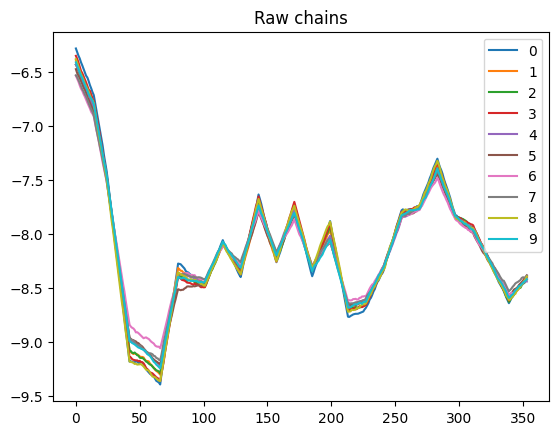

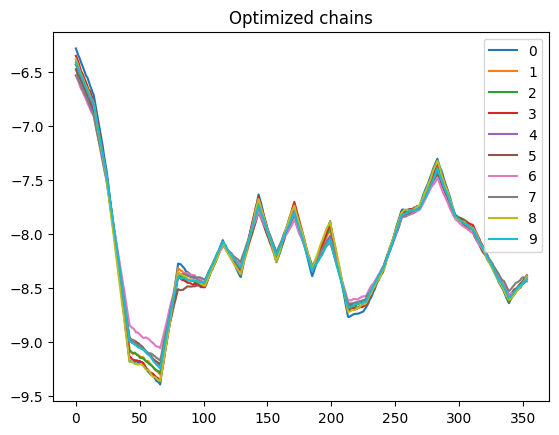

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.236  0.065   0.125    0.363      0.007    0.005      77.0     310.0   
eps    0.562  0.231   0.164    0.977      0.007    0.005    1221.0    3496.0   
p_out  0.154  0.095   0.010    0.329      0.001    0.001    9133.0   11653.0   

       r_hat  
sig     1.09  
eps     1.01  
p_out   1.00  


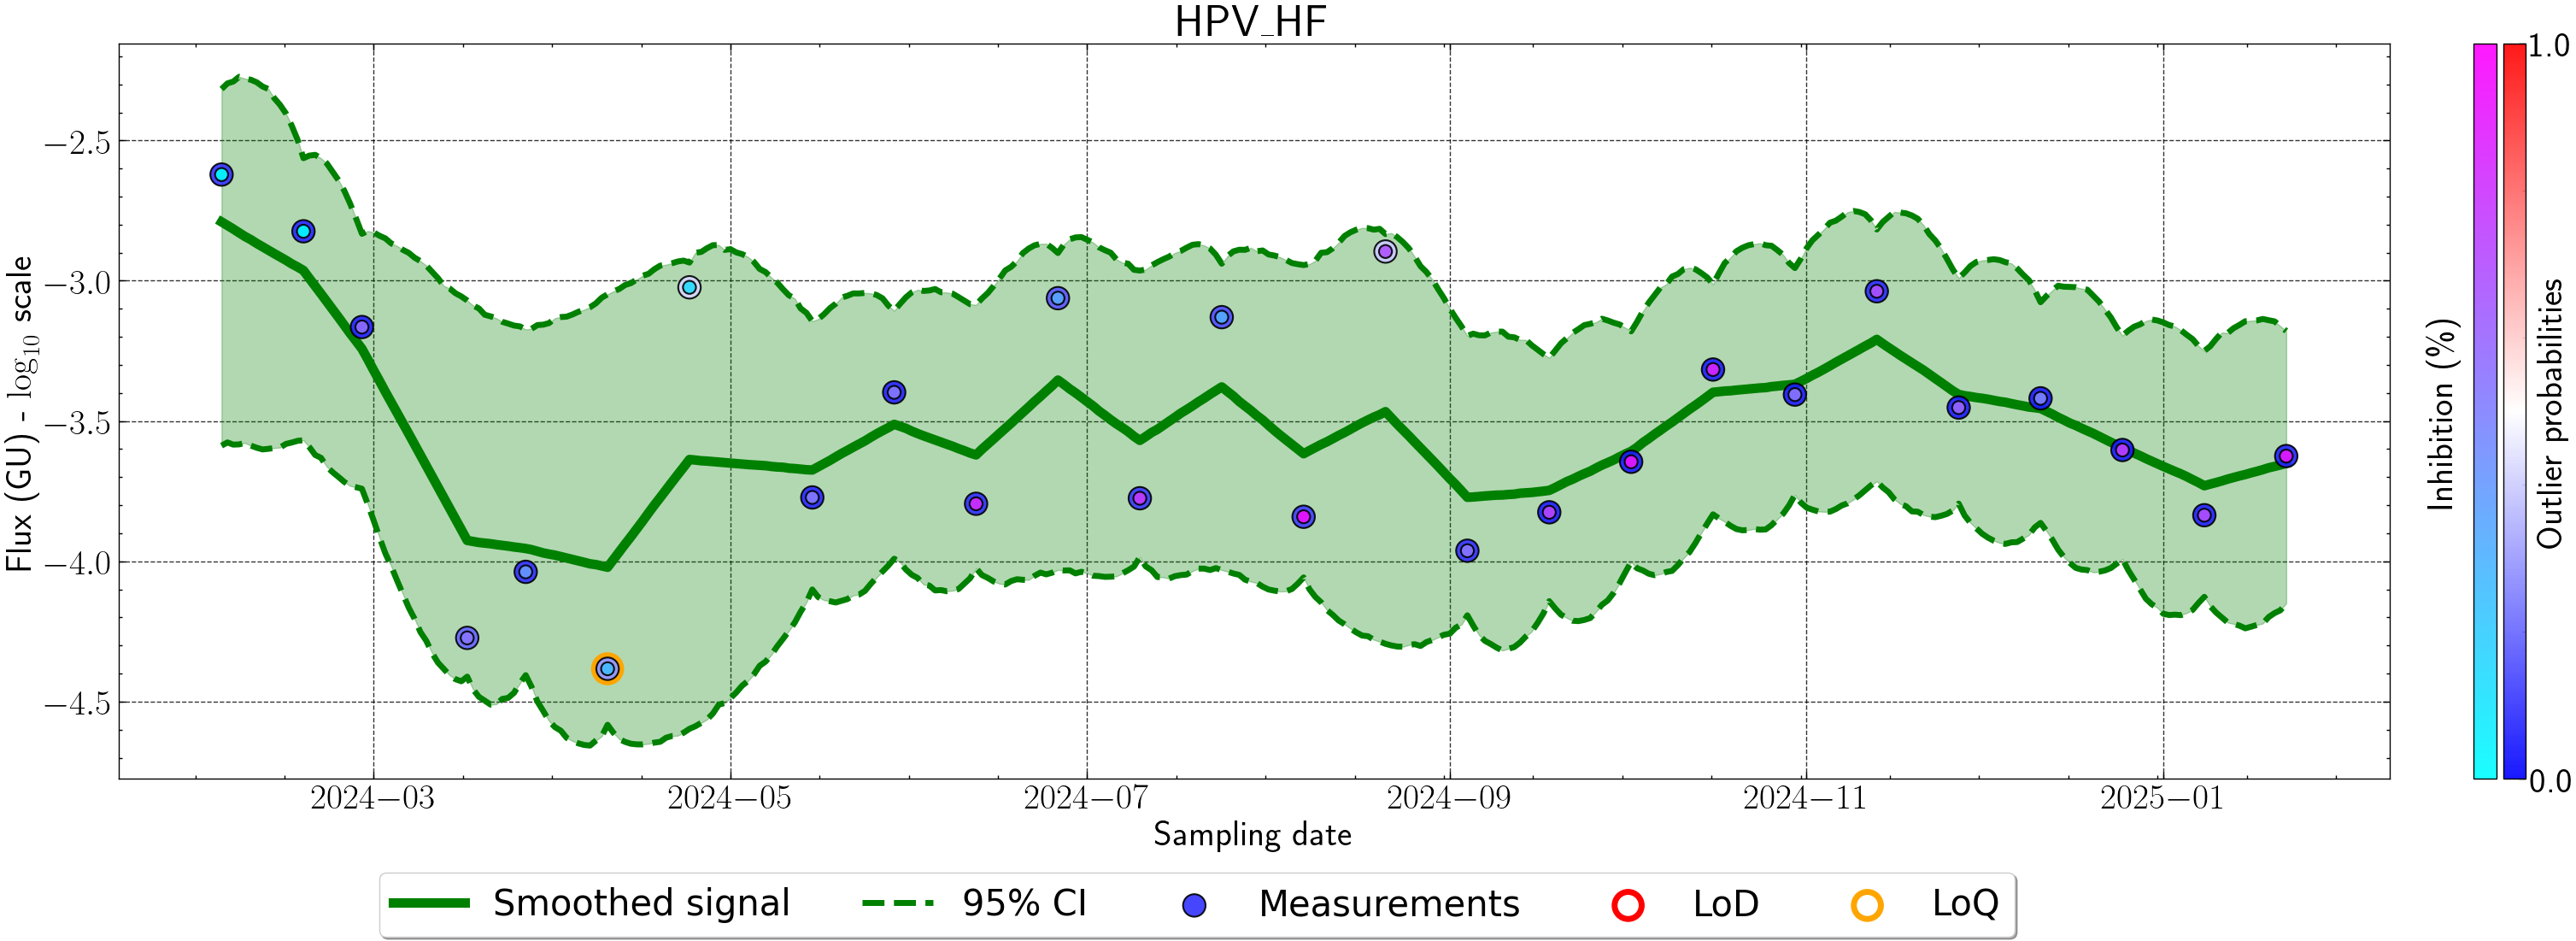

2024-6 [4, 5]
2024-8 [7, 8]
2024-10 [11, 12]
2024-12 [14, 15]
2024-14 [18, 19]
2024-16 [22, 23]
2024-18 [26, 27]
2024-21 [30, 31]
2024-23 [33, 34]
2024-25 [37, 38]
2024-27 [41, 42]
2024-29 [45, 46]
2024-31 [49]
2024-33 [53]
2024-35 [56]
2024-37 [59, 60]
2024-39 [63, 64]
2024-41 [67, 68]
2024-43 [71, 72]
2024-45 [75, 76]
2024-47 [79, 80]
2024-49 [83, 84]
2024-51 [87, 88]
2025-1 [91, 92]
2025-3 [95, 96]
2025-5 [99]
(26, 12) [4, 7, 11, 14, 18, 22, 26, 30, 33, 37, 41, 45, 49, 53, 56, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 599 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.268  0.089   0.124    0.433      0.007    0.005     169.0     431.0   
eps    0.673  0.299   0.162    1.199      0.011    0.008     731.0    4005.0   
p_out  0.166  0.097   0.009    0.339      0.001    0.001    3728.0   10077.0   

       r_hat  
sig     1.06  
eps     1.01  
p_out   1.00  


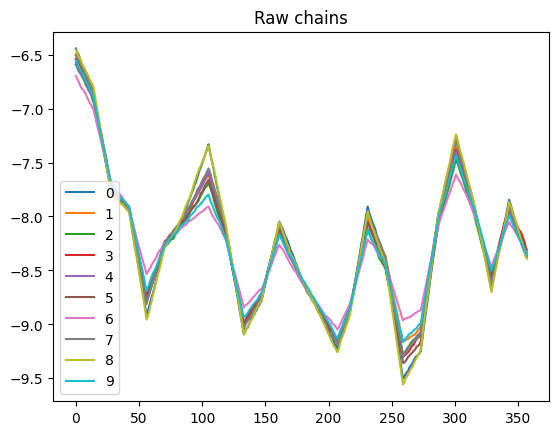

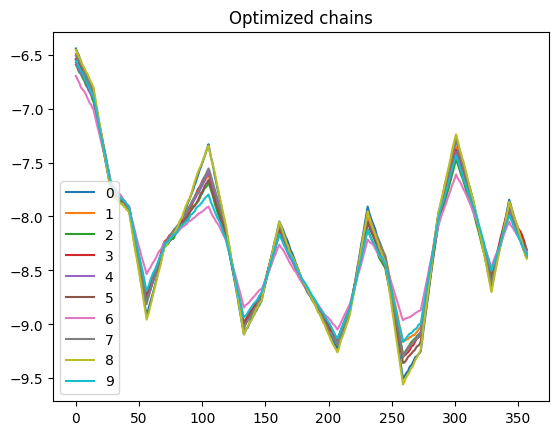

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.268  0.089   0.124    0.433      0.007    0.005     169.0     431.0   
eps    0.673  0.299   0.162    1.199      0.011    0.008     731.0    4005.0   
p_out  0.166  0.097   0.009    0.339      0.001    0.001    3728.0   10077.0   

       r_hat  
sig     1.06  
eps     1.01  
p_out   1.00  


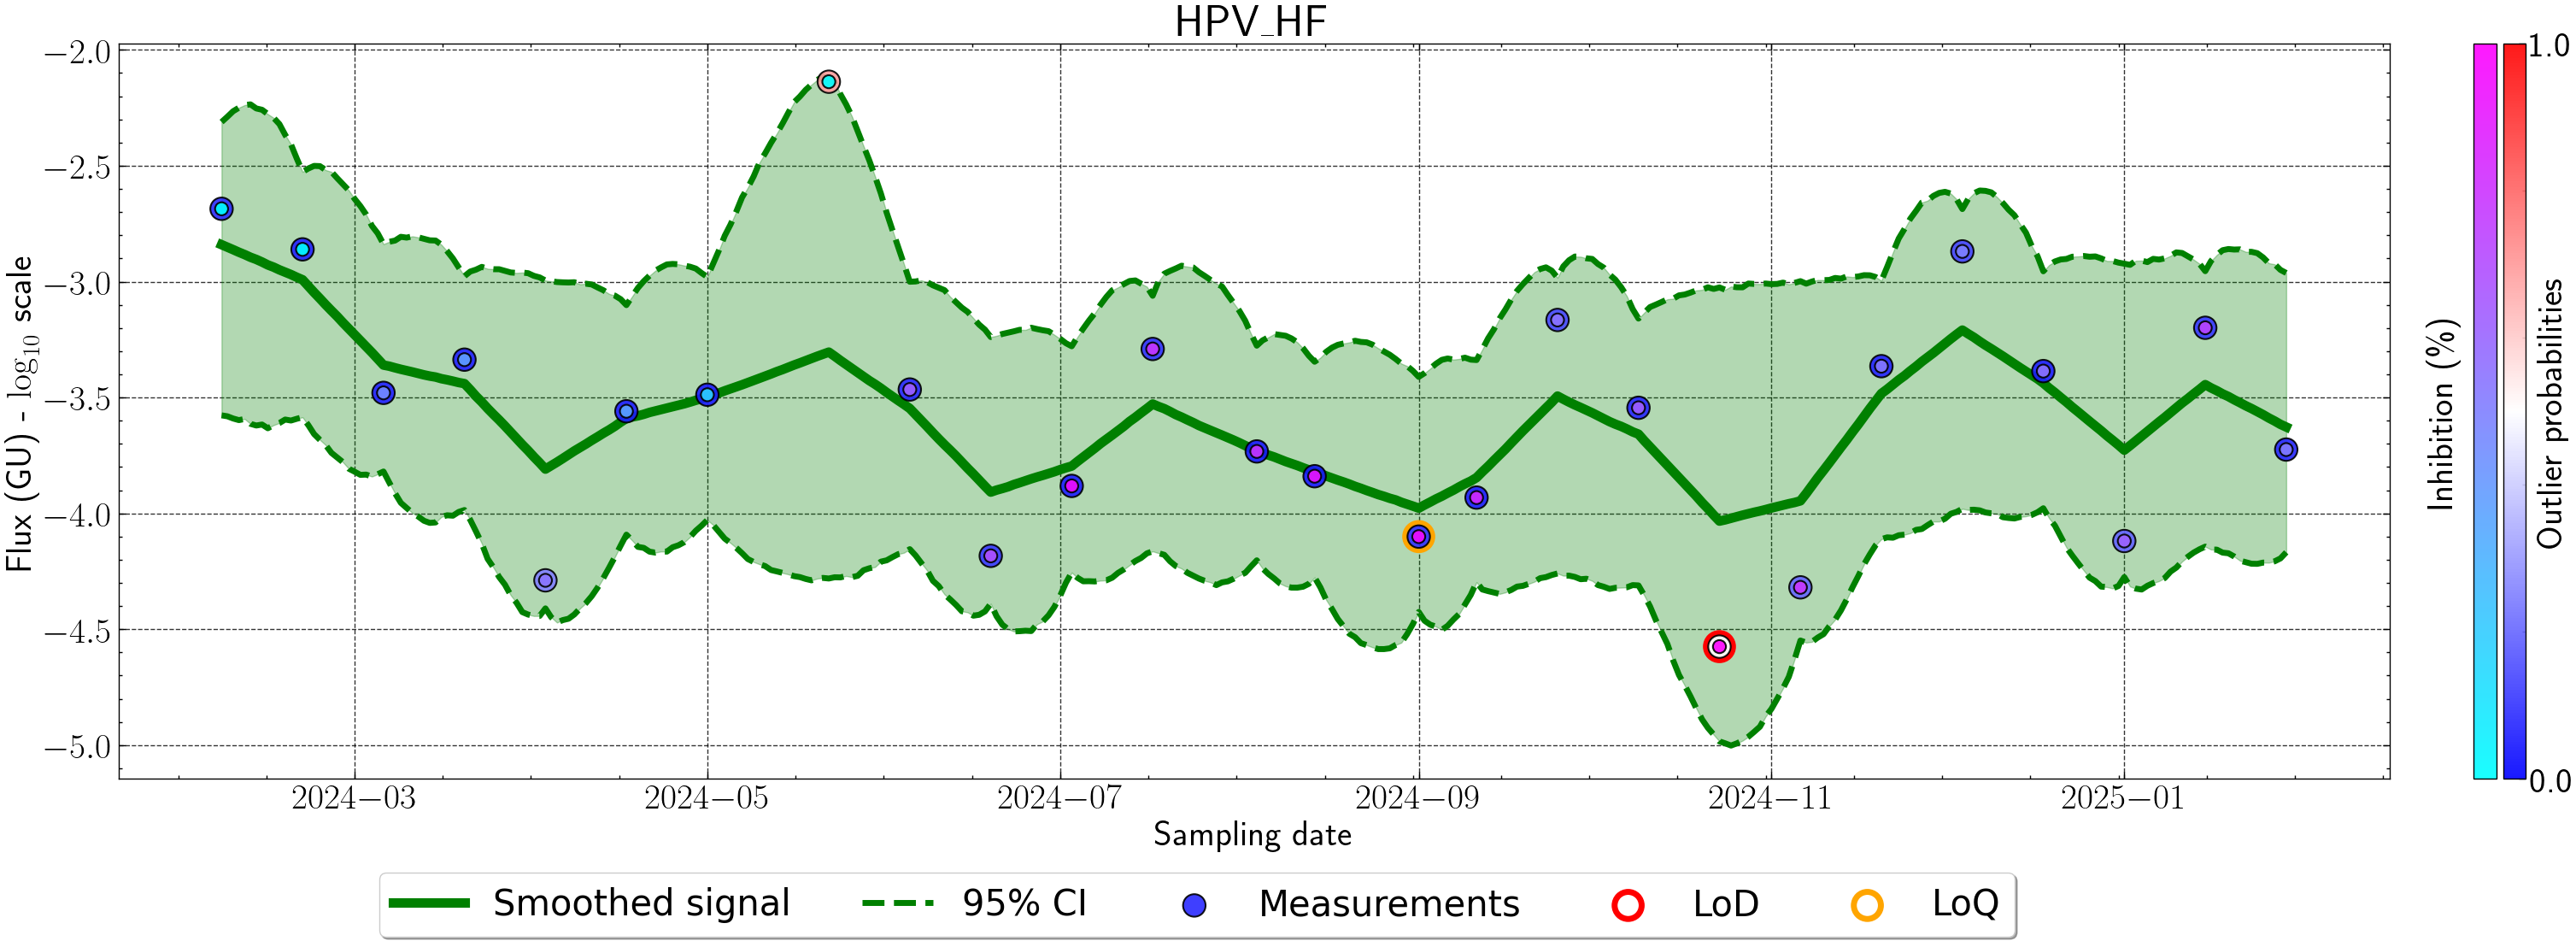

In [19]:
for i in [0, 1]:
    get_twice_a_month_subsamples(data_HPV_HF, index_positions=i)

In [20]:
def get_weekly_subsamples(data_HPV_HF, index_position=6, remove_those=[]):

    subsampled_data_HPV_HF = data_HPV_HF.copy()
    subsampled_data_HPV_HF = subsampled_data_HPV_HF[index_position::2]
    subsampled_data_HPV_HF = subsampled_data_HPV_HF.iloc[:,:-4]

    sub_data = subsampled_data_HPV_HF.copy()
    second_samples = sub_data.index.tolist()
    sub_data = sub_data.set_index('dateStart').resample('D').mean().reset_index()

    print(sub_data.loc[~sub_data.obs_HPV.isna()].shape, second_samples)

    observation_matrix = sub_data.obs.values
    lod_matrix = sub_data.lod.values
    loq_matrix = sub_data.loq.values

    nb_chains = 10
    tuning_iters = 4000
    sampling_iters = 2000
    
    scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, loq_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                                 export_name=None, 
                                 p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                                 RW_order=1)
    scou.fit()
    
    # Done
    notify_mac("Jupyter", "Work done !")

    selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    remove_those = remove_those
    for i in remove_those:
        selected_chains.remove(i)
    
    
    scou.visualize_latents(selected_chains)
    scou.predict(selected_chains)

    common_flux_data = {}
    this_molecule = 'HPV_HF_2025-09-25_ratio_phages_ss_weekly_' + str(index_position)

    sub_data.obs = np.log10(np.exp(sub_data.obs))
    sub_data.lod = np.log10(np.exp(sub_data.lod))
    sub_data.loq = np.log10(np.exp(sub_data.loq))

    sub_data['muX'] = scou.muX
    sub_data['ICL'] = scou.CIL
    sub_data['ICU'] = scou.CIU
    sub_data['pout'] = scou.pointwise_pout
    
    
    sub_data.muX = np.log10(np.exp(sub_data.muX))
    sub_data.ICL = np.log10(np.exp(sub_data.ICL))
    sub_data.ICU = np.log10(np.exp(sub_data.ICU))
    
    common_flux_data[this_molecule] = sub_data.copy()

    with plt.style.context(['science', 'notebook', 'grid']):
        LABEL_SIZE = 30
        TICK_SIZE = 30
        TITLE_SIZE = 38
        LEGEND_SIZE = 30
        DATES_SIZE = 18
        figsize = (28, 10) #figsize = (32, 10)
        
        plt.rc('axes', labelsize=LABEL_SIZE)
        plt.rc('xtick', labelsize=TICK_SIZE)   
        plt.rc('ytick', labelsize=TICK_SIZE)
        plt.rc('figure', titlesize=TITLE_SIZE)
        plt.rc('legend', fontsize=LEGEND_SIZE)
        plt.rcParams['text.usetex'] = True
        
        fig = plt.figure(figsize=figsize, layout="constrained")
        
        ax_dict = fig.subplot_mosaic(
            """
            A
            """
        )
        
        ### A
        ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='Smoothed signal', color='green', linewidth=8, zorder=3)
        
        ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
        ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
        
        ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.3, color='green')
    
        
        scatter_points = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, label='Measurements', 
                             c=sub_data.pout.values,
                             cmap='bwr', edgecolor='black', s=360, zorder=3,
                             linewidths=1.5, alpha=0.9, vmin=0, vmax=1)
    
        lod_points = ax_dict['A'].scatter(sub_data.loc[sub_data.obs<=sub_data.lod].dateStart.values,
                                          sub_data.loc[sub_data.obs<=sub_data.lod].obs.values,
                             color='none', edgecolor='red', s=520, zorder=2, linewidth=5, label="LoD")
    
        loq_points = ax_dict['A'].scatter(sub_data.loc[(sub_data.obs<=sub_data.loq)&(sub_data.obs>sub_data.lod)].dateStart.values,
                                          sub_data.loc[(sub_data.obs<=sub_data.loq)&(sub_data.obs>sub_data.lod)].obs.values,
                             color='none', edgecolor='orange', s=520, zorder=2, linewidth=5, label="LoQ")
    
        scatter_points_2 = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, 
                             c=sub_data.inhibition.values, cmap='cool', edgecolor='black', s=120, zorder=3,
                             linewidths=1.5, alpha=0.9, vmin=0, vmax=1)
    
        ax_dict['A'].set_ylabel("Flux (GU) - $\log_{10}$ scale")
        ax_dict['A'].set_xlabel("Sampling date")
        ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
        ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
        ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
        ax_dict['A'].set_title('HPV_HF', size=TITLE_SIZE)
    
        ### Outlier probability legend:
        cmin, cmax = 0.0, 1.0 
        axins1 = inset_axes(ax_dict['A'], width='50%', height='100%', 
                            bbox_to_anchor=(1.075-0.035, 0, 0.02, 1), 
                            bbox_transform=ax_dict['A'].transAxes, 
                            borderpad=0)
        axins1.grid(False)
        cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')

        custom_ticks = [0.0, 1.0] 
        cbar.set_ticks(custom_ticks)
    
        ref_label = ax_dict['A'].get_yticklabels()[0] 
        font_props = ref_label.get_fontproperties()
        decimal_places = 1
        cbar.ax.set_yticklabels([f"{val:.{decimal_places}f}" for val in custom_ticks], fontsize=TICK_SIZE, fontproperties=font_props)

        cbar.ax.set_ylabel('Outlier probabilities', size=TICK_SIZE, labelpad=-30)
    
        axins1 = inset_axes(ax_dict['A'], width='50%', height='100%', 
                            bbox_to_anchor=(1.062-0.035, 0, 0.02, 1), 
                            bbox_transform=ax_dict['A'].transAxes, 
                            borderpad=0)
        axins1.grid(False)
        cbar = fig.colorbar(scatter_points_2, cax=axins1, orientation='vertical')
        cbar.set_ticks([])

        cbar.ax.set_ylabel('Inhibition (\%)', size=TICK_SIZE, labelpad=-60)
    
        # Main legend
        plt.rcParams['text.usetex'] = False
        h1, l1 = ax_dict['A'].get_legend_handles_labels()
        fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
        
        plt.show()

    for molecule in list(common_flux_data.keys()):
        this_file = common_flux_data[molecule]
        this_file.to_csv('../outputs/files/1510/' + molecule + '.csv', sep=';', index=False)

(50, 12) [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 464 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.300  0.100   0.140    0.493      0.012    0.009      61.0     450.0   
eps    0.950  0.349   0.235    1.518      0.020    0.014     314.0    1618.0   
p_out  0.171  0.083   0.027    0.324      0.001    0.001    9324.0   12156.0   

       r_hat  
sig     1.12  
eps     1.03  
p_out   1.00  


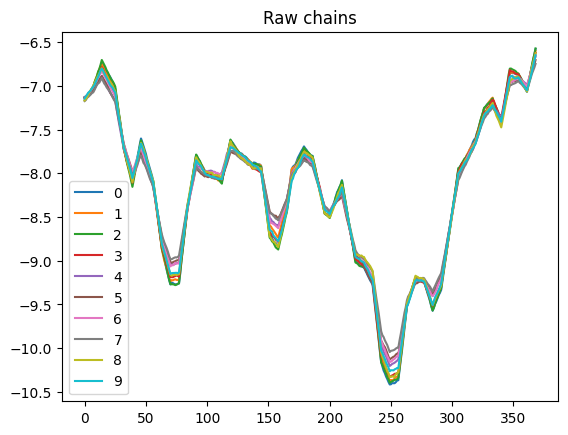

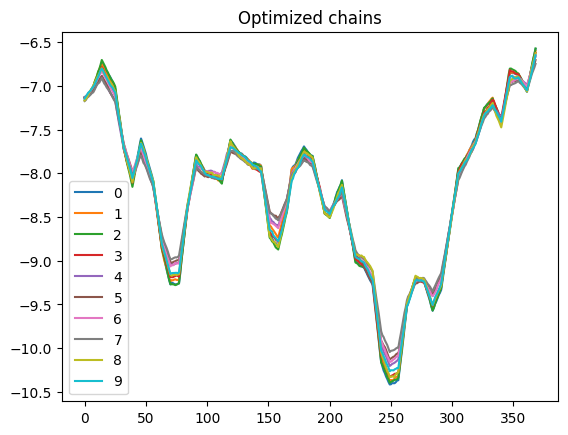

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.300  0.100   0.140    0.493      0.012    0.009      61.0     450.0   
eps    0.950  0.349   0.235    1.518      0.020    0.014     314.0    1618.0   
p_out  0.171  0.083   0.027    0.324      0.001    0.001    9324.0   12156.0   

       r_hat  
sig     1.12  
eps     1.03  
p_out   1.00  


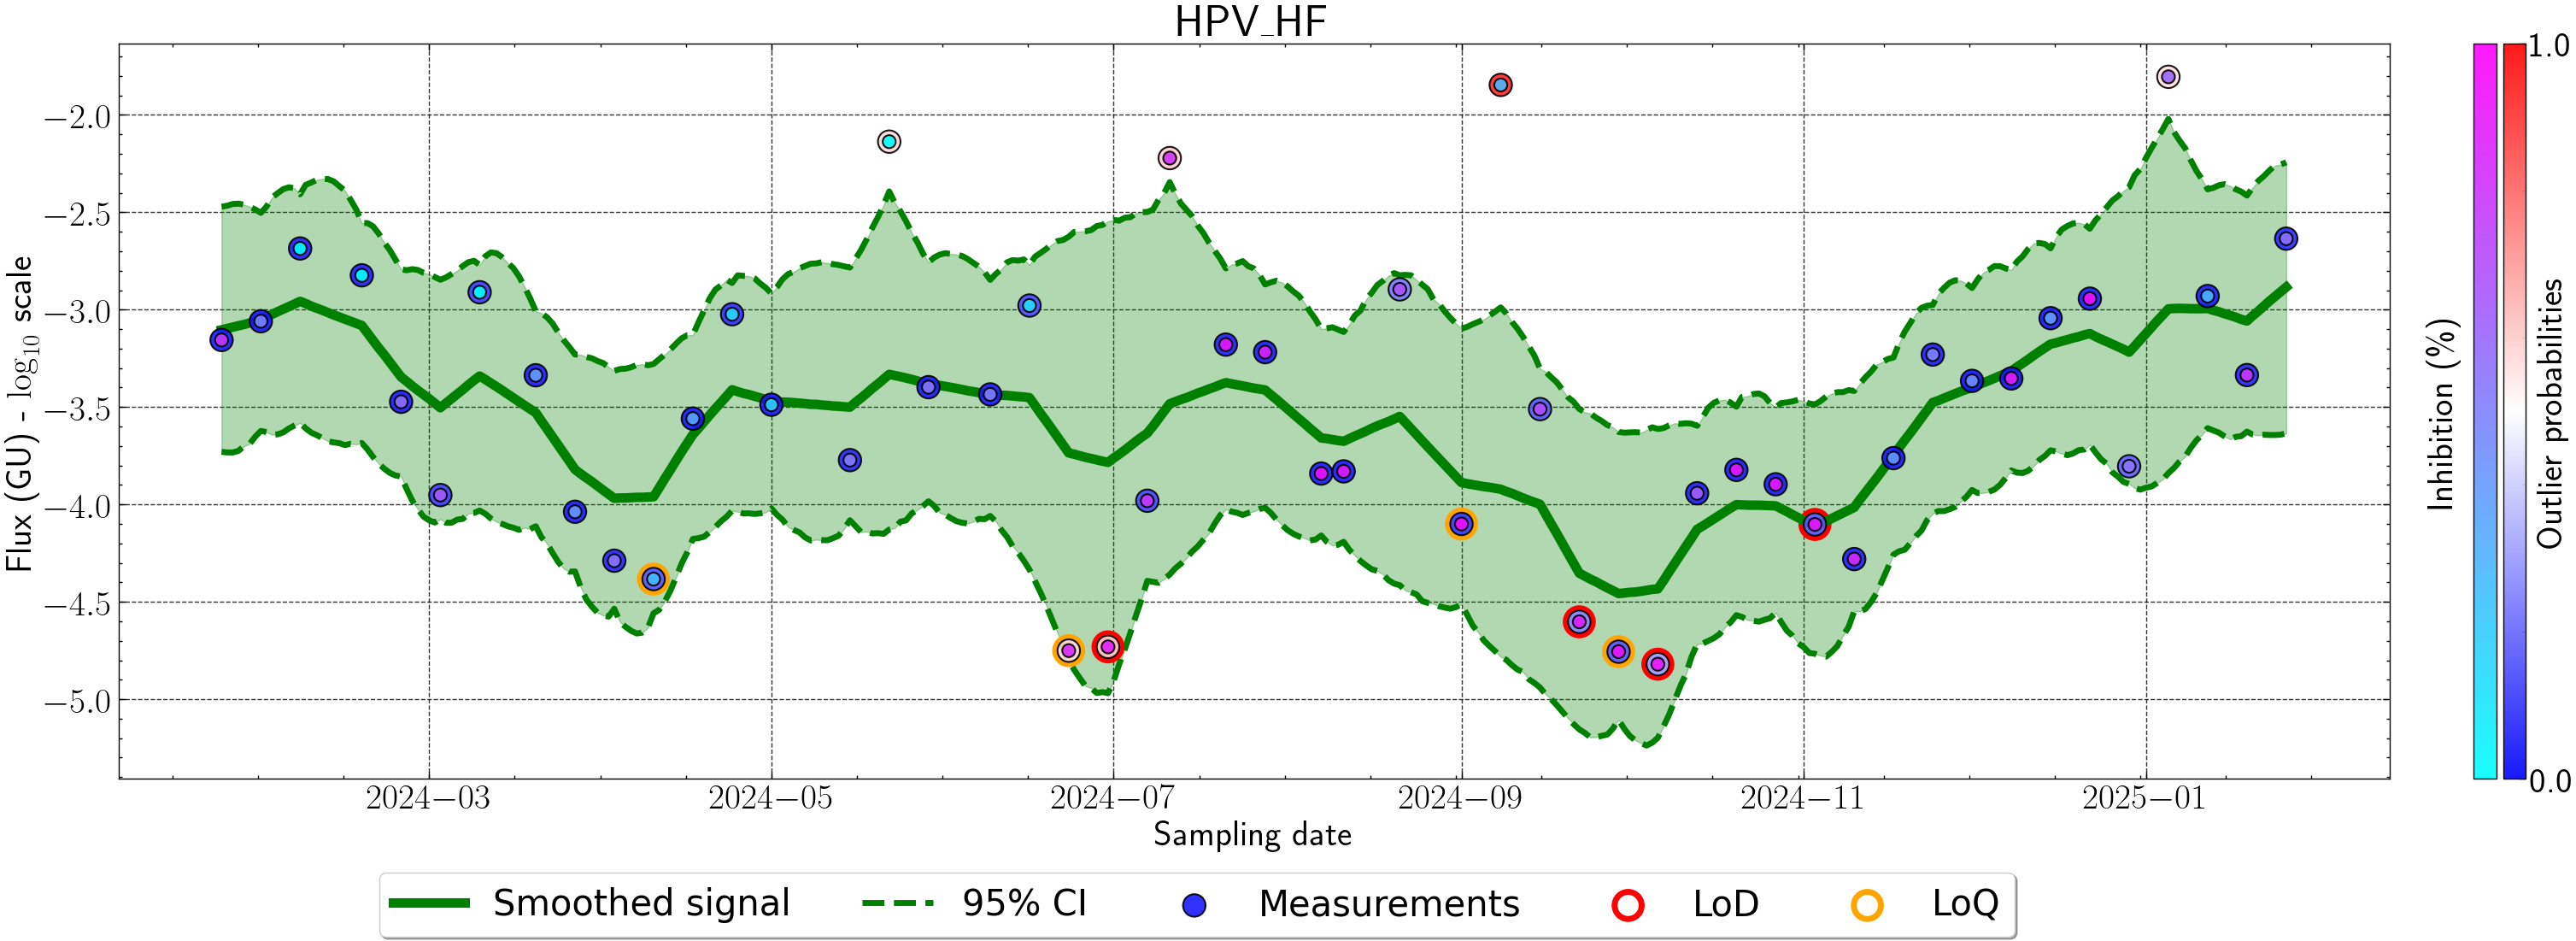

(50, 12) [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 331 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.256  0.065   0.131    0.375      0.005    0.003     176.0     399.0   
eps    0.559  0.194   0.204    0.910      0.007    0.005     758.0    3392.0   
p_out  0.123  0.062   0.018    0.239      0.001    0.000   11691.0   12243.0   

       r_hat  
sig     1.06  
eps     1.02  
p_out   1.00  


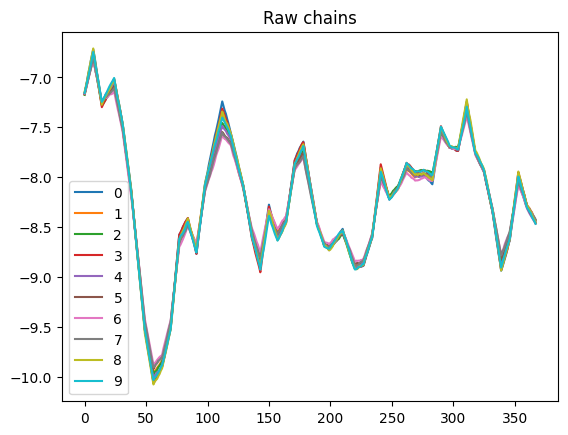

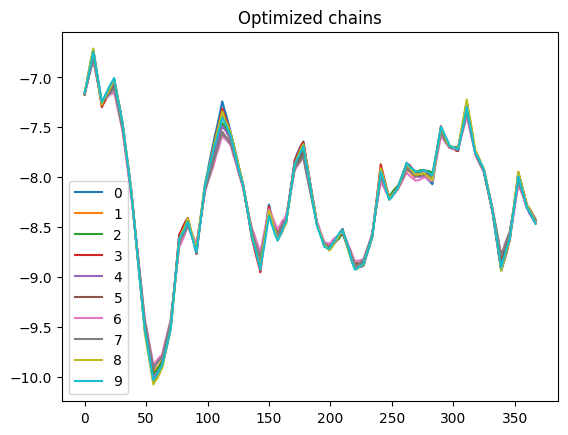

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.256  0.065   0.131    0.375      0.005    0.003     176.0     399.0   
eps    0.559  0.194   0.204    0.910      0.007    0.005     758.0    3392.0   
p_out  0.123  0.062   0.018    0.239      0.001    0.000   11691.0   12243.0   

       r_hat  
sig     1.06  
eps     1.02  
p_out   1.00  


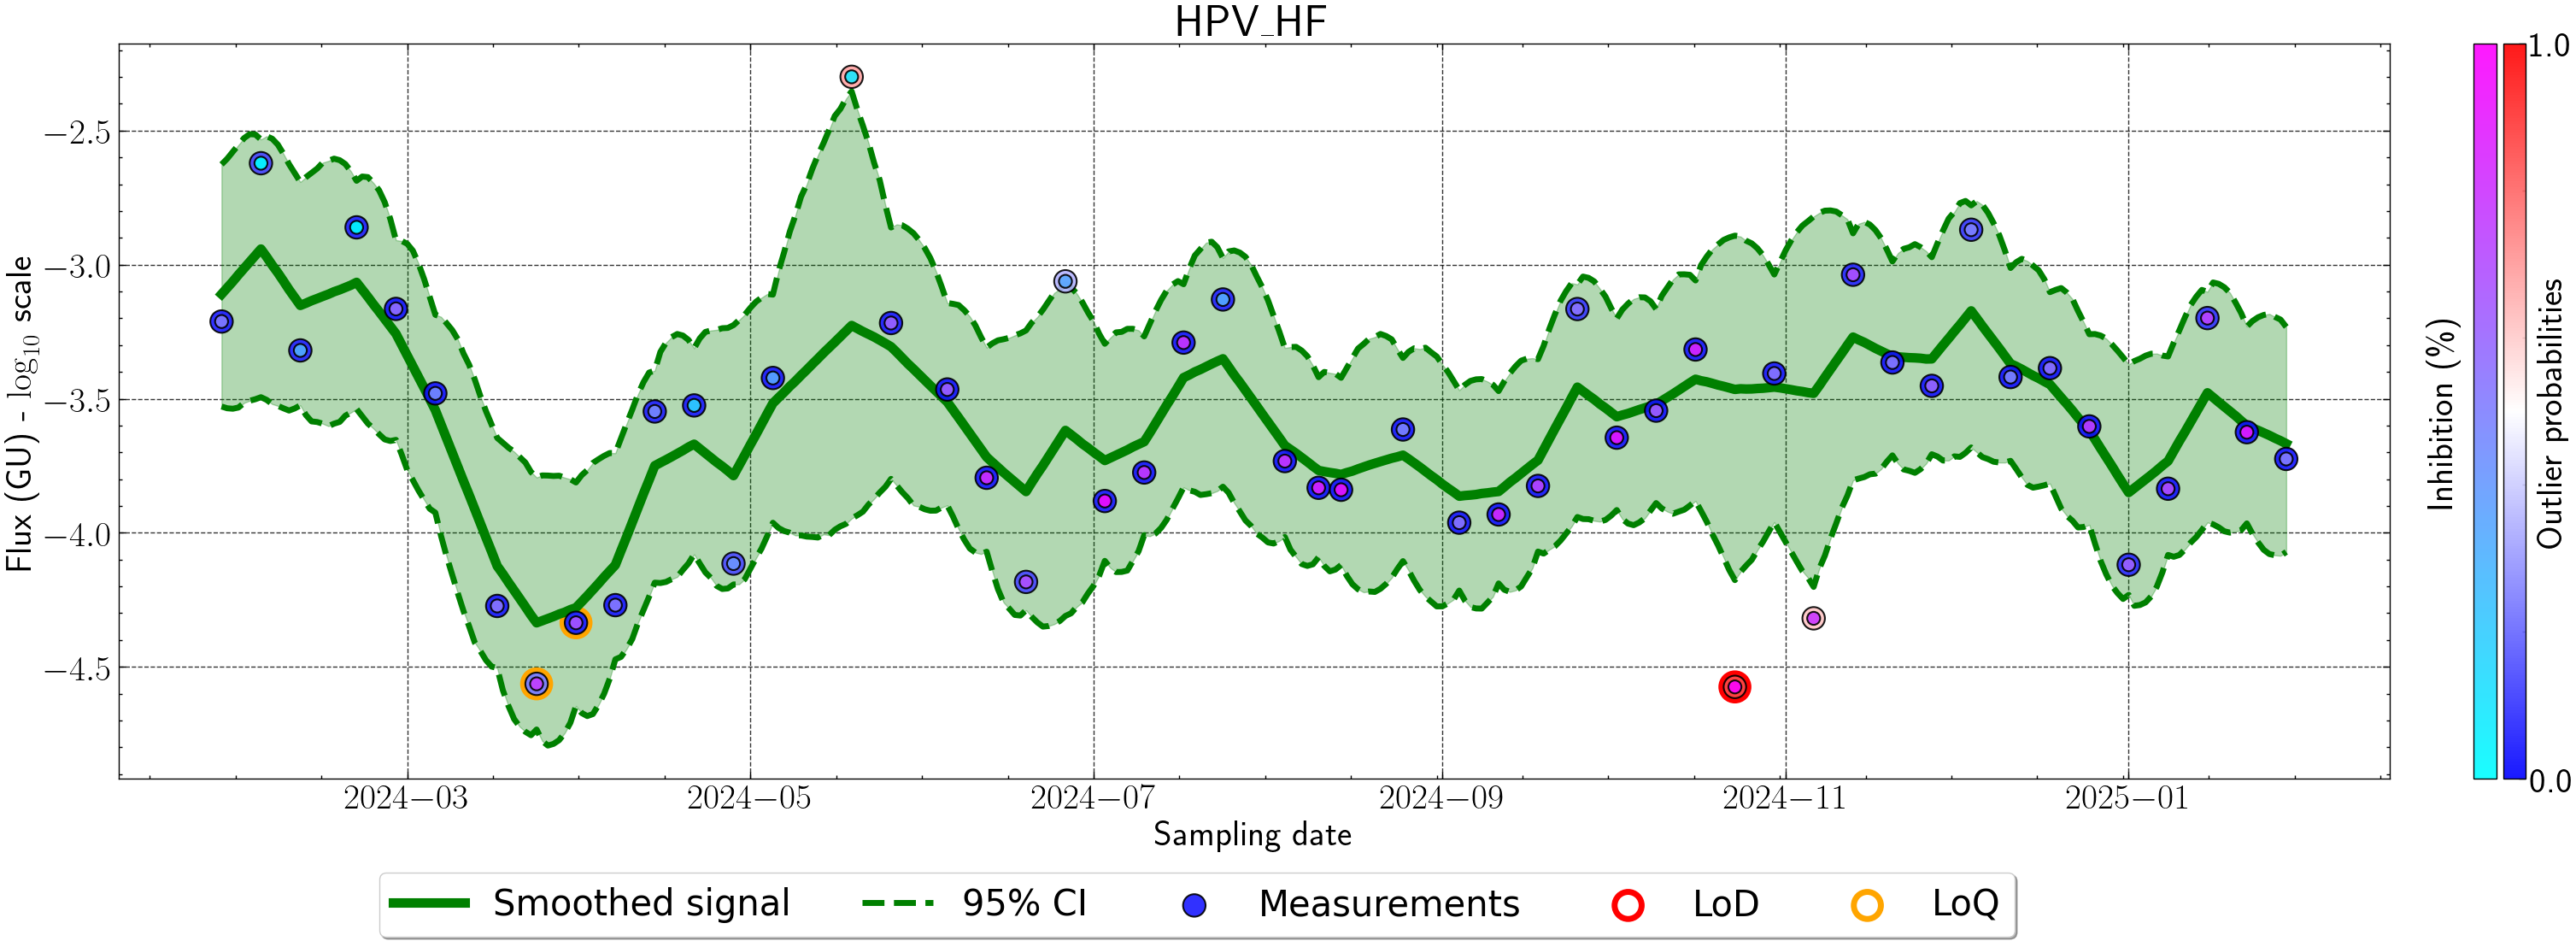

In [21]:
for i in [0, 1]:
    get_weekly_subsamples(data_HPV_HF, index_position=i)

2024-2 [3, 4, 5, 6, 7, 8, 9]
2024-3 [10, 11, 12, 13, 14, 15, 16, 17]
2024-4 [18, 19, 20, 21, 22, 23, 24, 25]
2024-5 [26, 27, 28, 29, 30, 31, 32]
2024-6 [33, 34, 35, 36, 37, 38, 39, 40]
2024-7 [41, 42, 43, 44, 45, 46, 47, 48]
2024-8 [49, 50, 51, 52, 53, 54, 55]
2024-9 [56, 57, 58, 59, 60, 61, 62, 63, 64]
2024-10 [65, 66, 67, 68, 69, 70, 71, 72, 73]
2024-11 [74, 75, 76, 77, 78, 79, 80, 81]
2024-12 [82, 83, 84, 85, 86, 87, 88, 89, 90]
2025-1 [91, 92, 93, 94, 95, 96, 97, 98, 99]
(12, 12) [3, 10, 18, 26, 33, 41, 49, 56, 65, 74, 82, 91]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 936 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.282  0.105   0.117    0.470      0.016    0.012      43.0     109.0   
eps    0.625  0.395   0.131    1.278      0.005    0.003    4848.0    7753.0   
p_out  0.258  0.146   0.019    0.524      0.003    0.002    3077.0    4079.0   

       r_hat  
sig     1.19  
eps     1.00  
p_out   1.01  


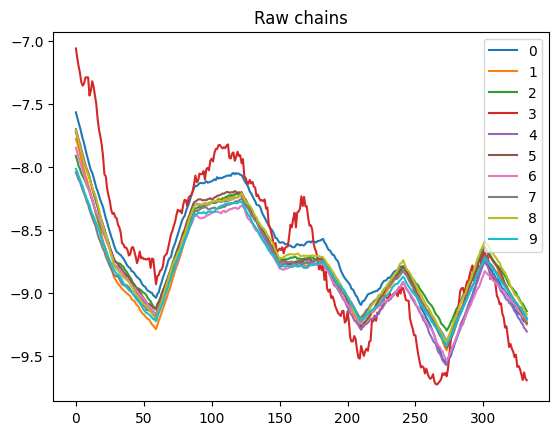

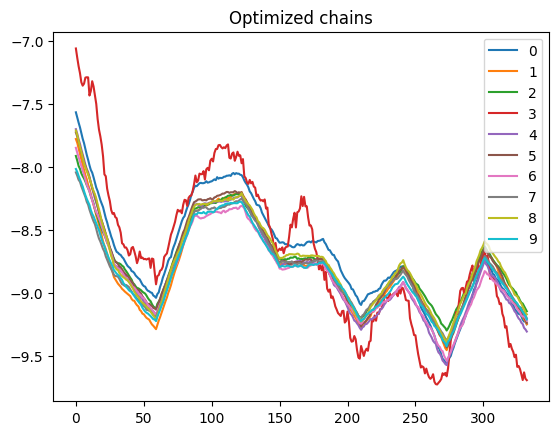

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.282  0.105   0.117    0.470      0.016    0.012      43.0     109.0   
eps    0.625  0.395   0.131    1.278      0.005    0.003    4848.0    7753.0   
p_out  0.258  0.146   0.019    0.524      0.003    0.002    3077.0    4079.0   

       r_hat  
sig     1.19  
eps     1.00  
p_out   1.01  


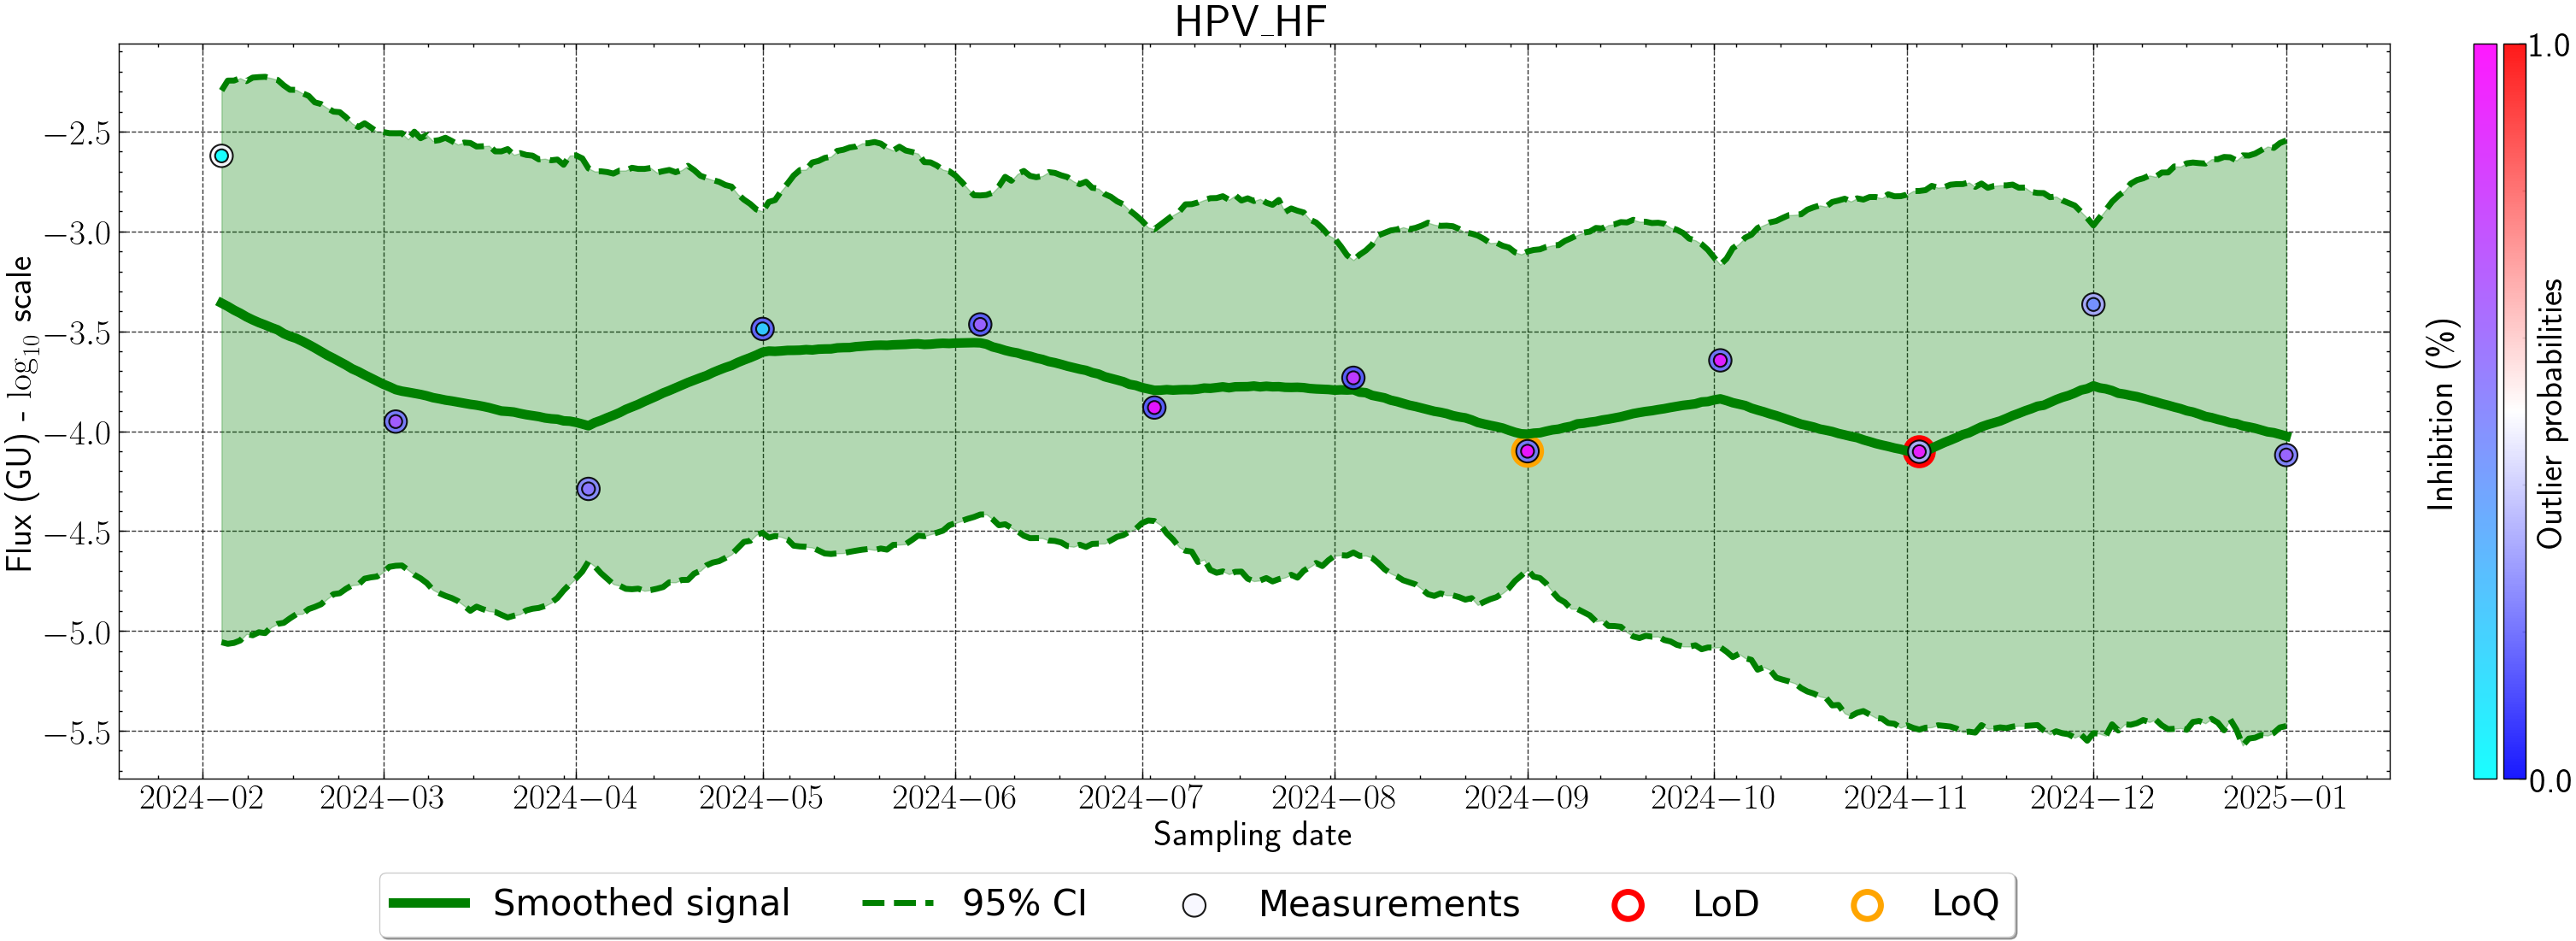

2024-2 [3, 4, 5, 6, 7, 8, 9]
2024-3 [10, 11, 12, 13, 14, 15, 16, 17]
2024-4 [18, 19, 20, 21, 22, 23, 24, 25]
2024-5 [26, 27, 28, 29, 30, 31, 32]
2024-6 [33, 34, 35, 36, 37, 38, 39, 40]
2024-7 [41, 42, 43, 44, 45, 46, 47, 48]
2024-8 [49, 50, 51, 52, 53, 54, 55]
2024-9 [56, 57, 58, 59, 60, 61, 62, 63, 64]
2024-10 [65, 66, 67, 68, 69, 70, 71, 72, 73]
2024-11 [74, 75, 76, 77, 78, 79, 80, 81]
2024-12 [82, 83, 84, 85, 86, 87, 88, 89, 90]
2025-1 [91, 92, 93, 94, 95, 96, 97, 98, 99]
(12, 12) [4, 11, 19, 27, 34, 42, 50, 57, 66, 75, 83, 92]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 603 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.362  0.132   0.148    0.572      0.011    0.009     182.0     250.0   
eps    0.605  0.395   0.120    1.315      0.006    0.004    4392.0    9774.0   
p_out  0.194  0.123   0.008    0.420      0.002    0.002    3519.0    7515.0   

       r_hat  
sig     1.07  
eps     1.00  
p_out   1.00  


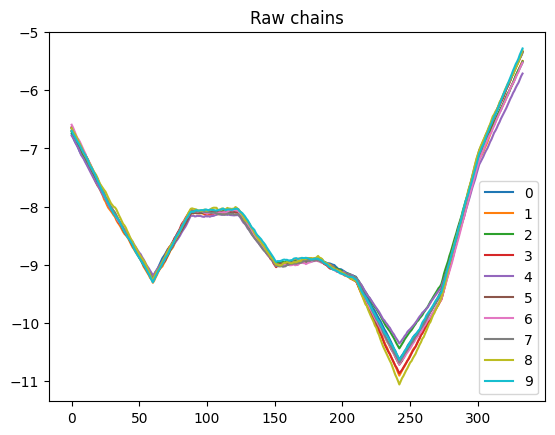

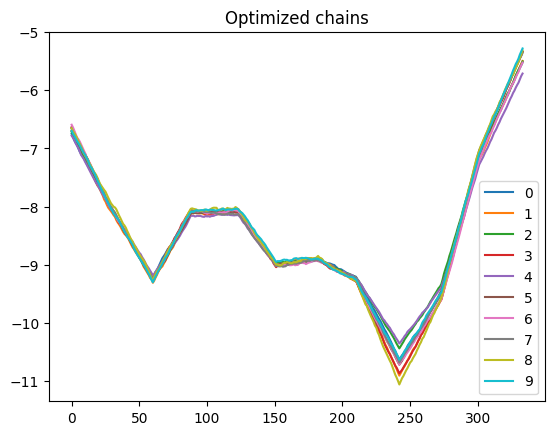

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.362  0.132   0.148    0.572      0.011    0.009     182.0     250.0   
eps    0.605  0.395   0.120    1.315      0.006    0.004    4392.0    9774.0   
p_out  0.194  0.123   0.008    0.420      0.002    0.002    3519.0    7515.0   

       r_hat  
sig     1.07  
eps     1.00  
p_out   1.00  


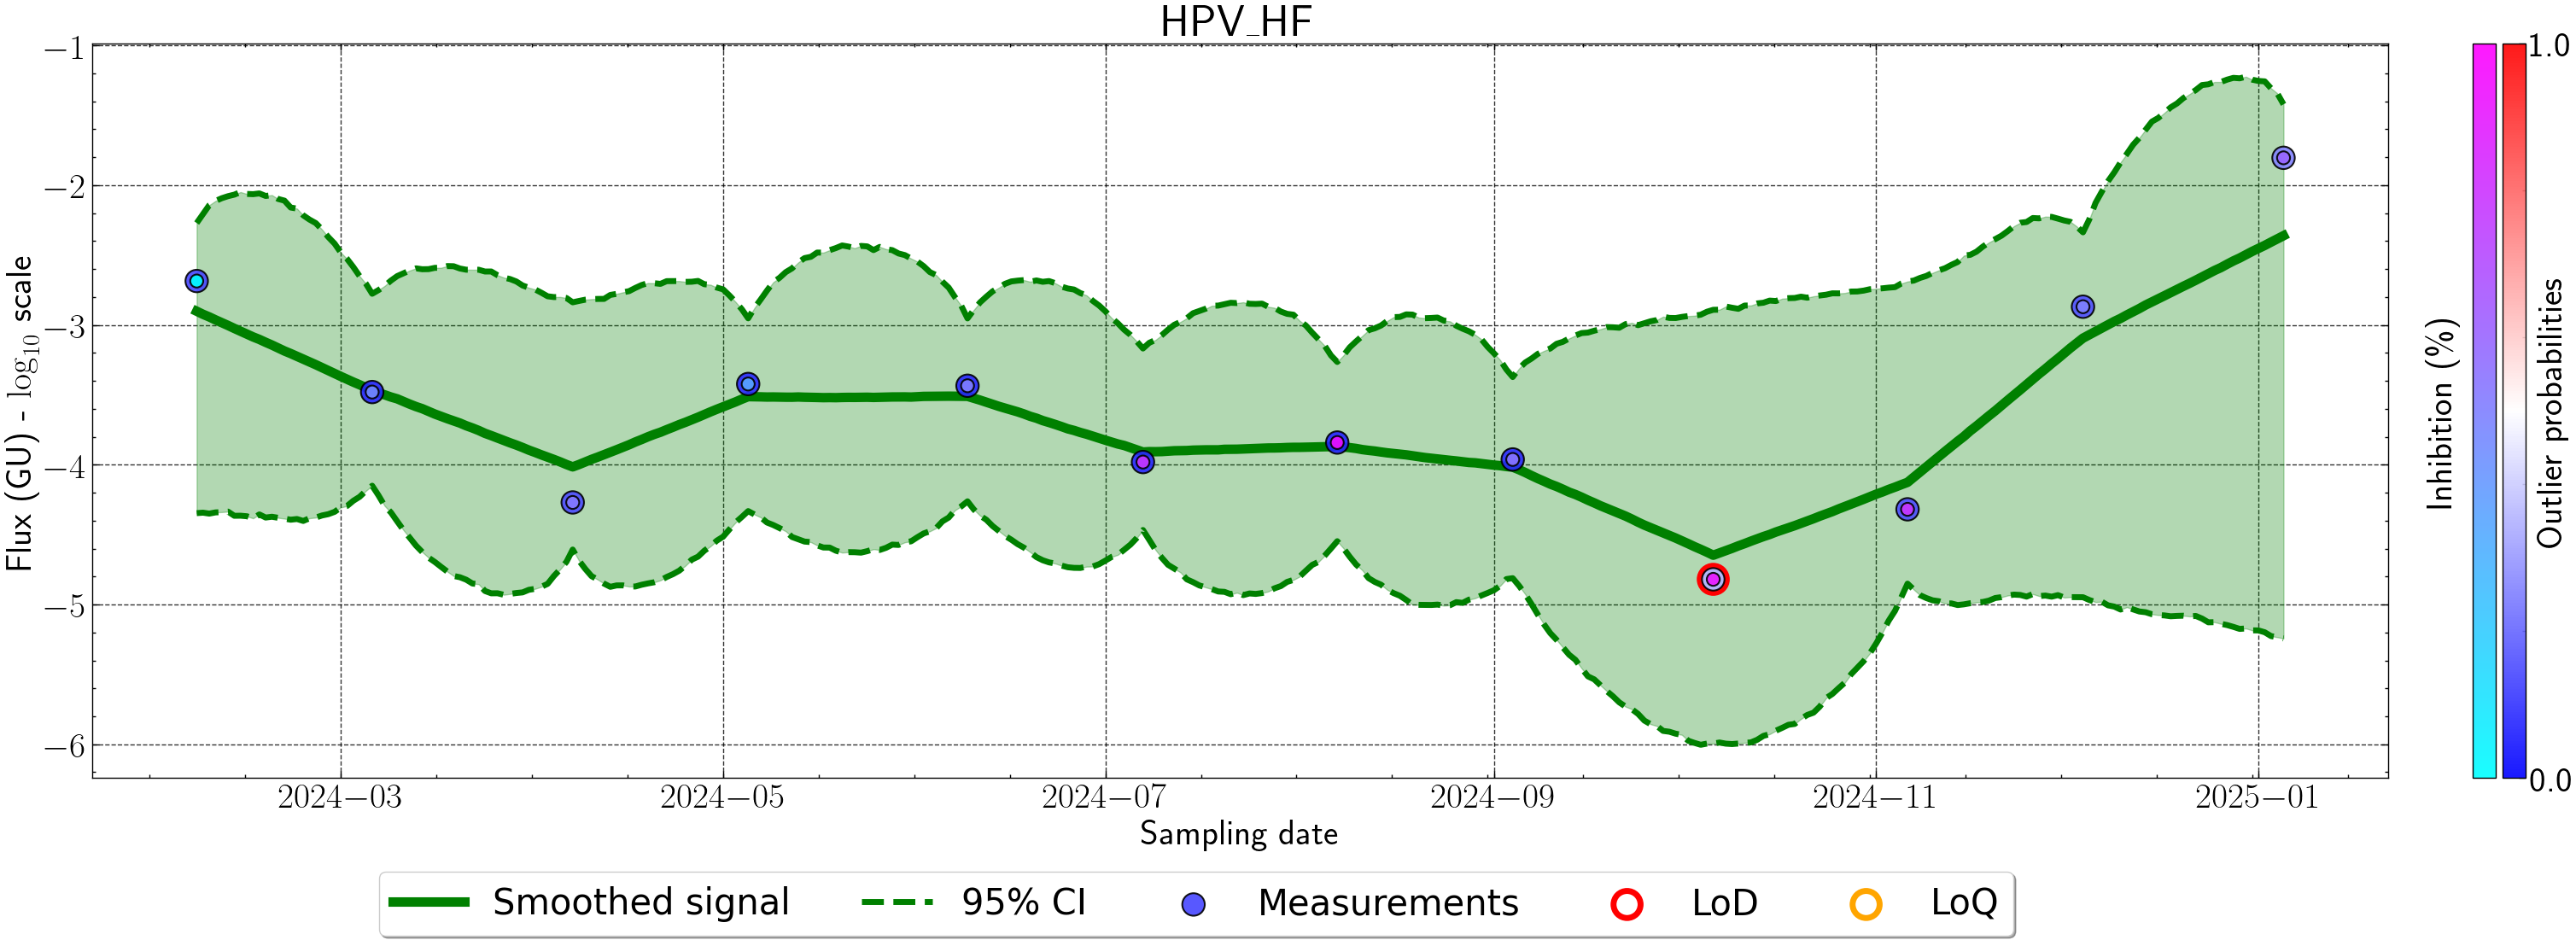

2024-2 [3, 4, 5, 6, 7, 8, 9]
2024-3 [10, 11, 12, 13, 14, 15, 16, 17]
2024-4 [18, 19, 20, 21, 22, 23, 24, 25]
2024-5 [26, 27, 28, 29, 30, 31, 32]
2024-6 [33, 34, 35, 36, 37, 38, 39, 40]
2024-7 [41, 42, 43, 44, 45, 46, 47, 48]
2024-8 [49, 50, 51, 52, 53, 54, 55]
2024-9 [56, 57, 58, 59, 60, 61, 62, 63, 64]
2024-10 [65, 66, 67, 68, 69, 70, 71, 72, 73]
2024-11 [74, 75, 76, 77, 78, 79, 80, 81]
2024-12 [82, 83, 84, 85, 86, 87, 88, 89, 90]
2025-1 [91, 92, 93, 94, 95, 96, 97, 98, 99]
(12, 12) [5, 12, 20, 28, 35, 43, 51, 58, 67, 76, 84, 93]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 875 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.270  0.110   0.119    0.469      0.013    0.009      54.0     173.0   
eps    0.630  0.377   0.118    1.301      0.004    0.003    7021.0   10430.0   
p_out  0.254  0.139   0.030    0.508      0.010    0.009     461.0      89.0   

       r_hat  
sig     1.14  
eps     1.01  
p_out   1.03  


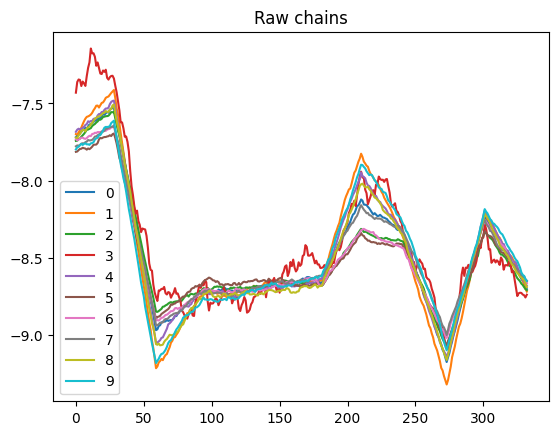

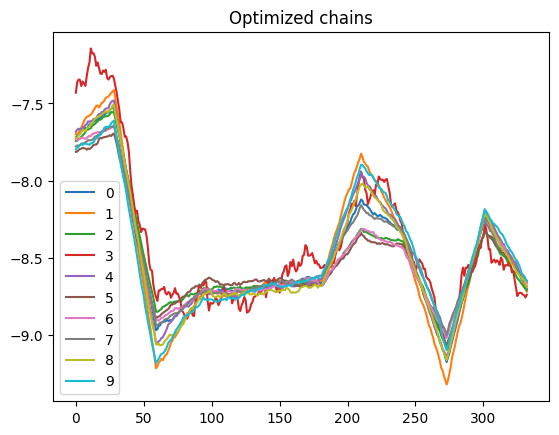

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.270  0.110   0.119    0.469      0.013    0.009      54.0     173.0   
eps    0.630  0.377   0.118    1.301      0.004    0.003    7021.0   10430.0   
p_out  0.254  0.139   0.030    0.508      0.010    0.009     461.0      89.0   

       r_hat  
sig     1.14  
eps     1.01  
p_out   1.03  


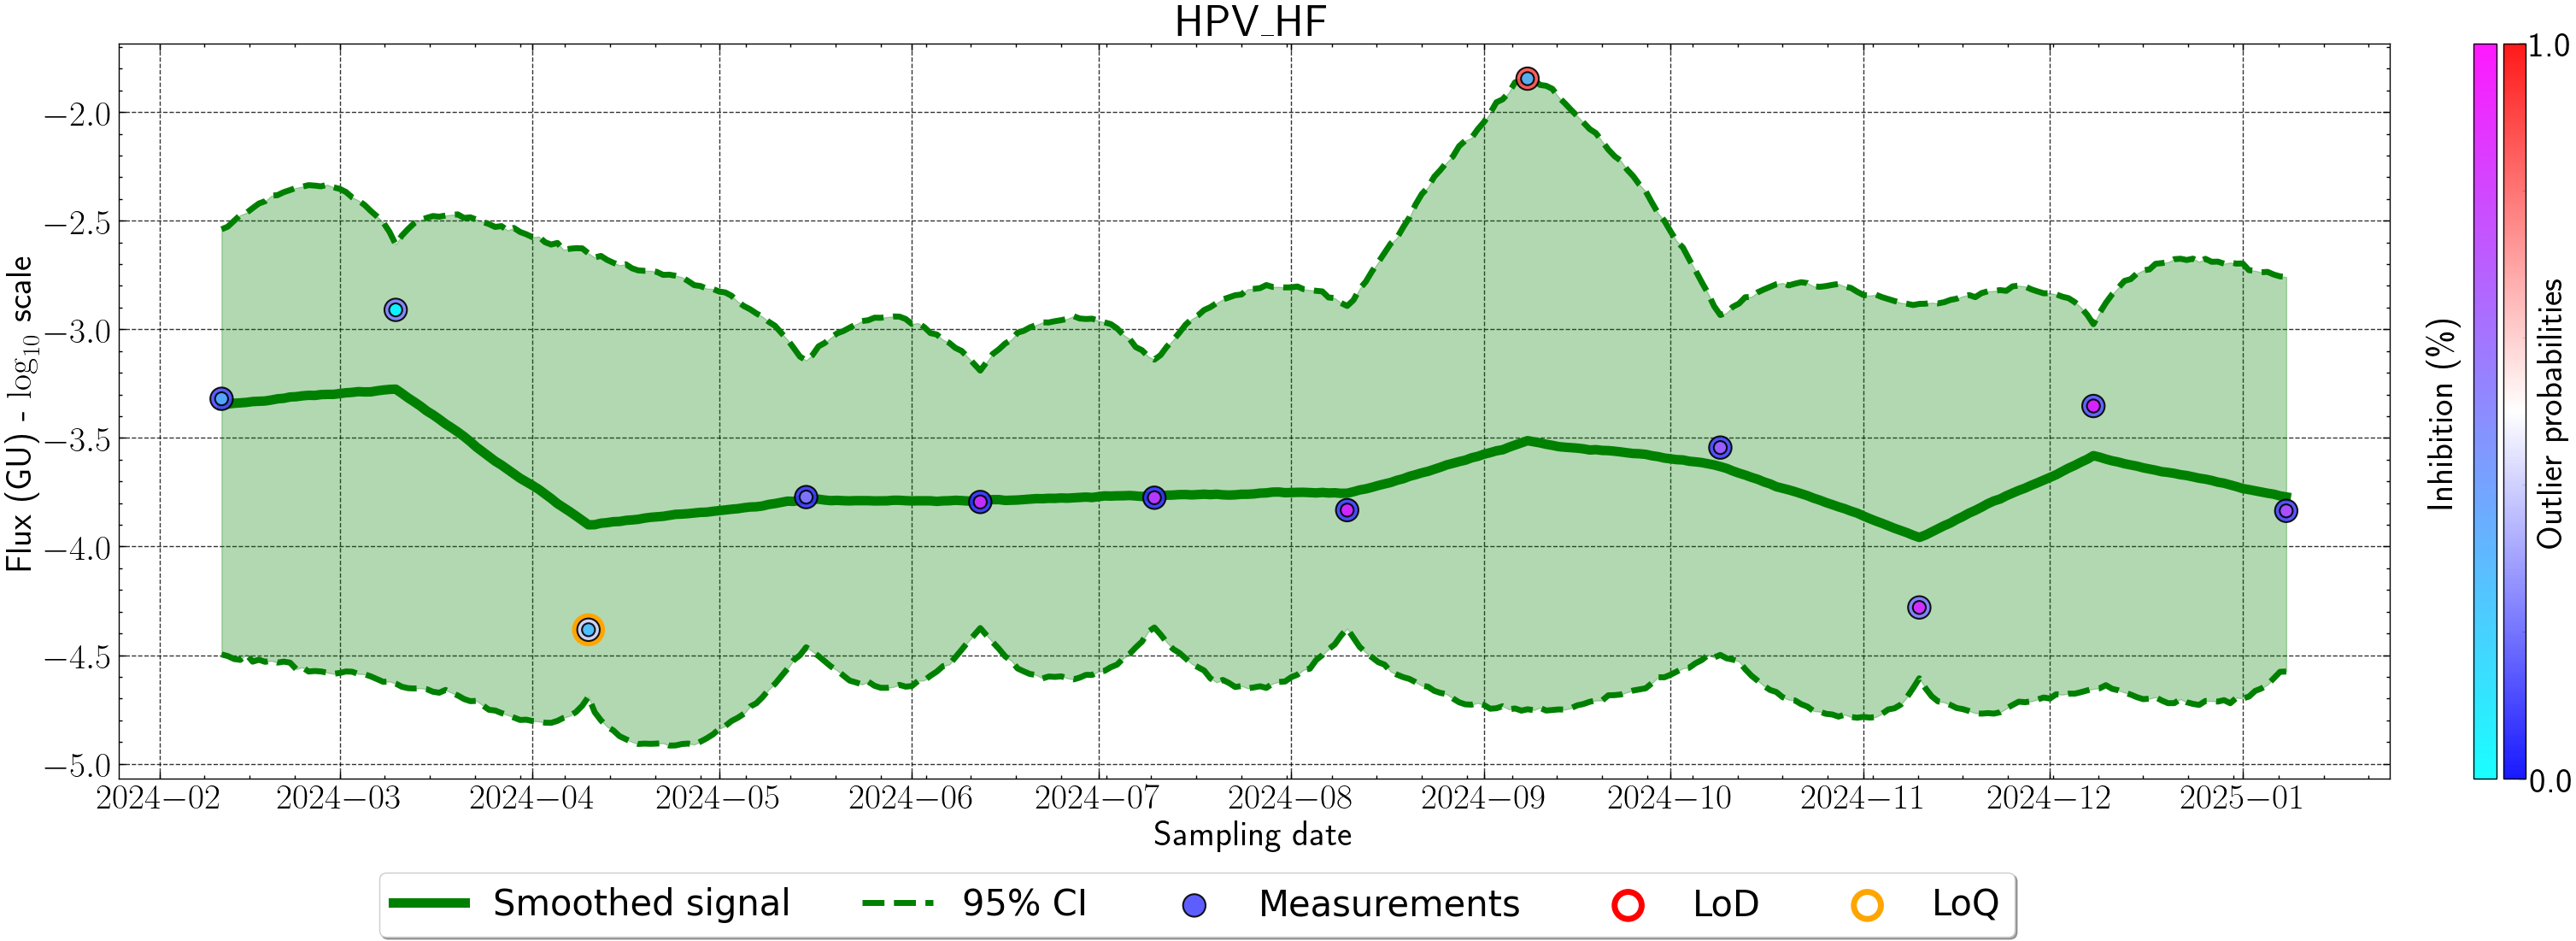

2024-2 [3, 4, 5, 6, 7, 8, 9]
2024-3 [10, 11, 12, 13, 14, 15, 16, 17]
2024-4 [18, 19, 20, 21, 22, 23, 24, 25]
2024-5 [26, 27, 28, 29, 30, 31, 32]
2024-6 [33, 34, 35, 36, 37, 38, 39, 40]
2024-7 [41, 42, 43, 44, 45, 46, 47, 48]
2024-8 [49, 50, 51, 52, 53, 54, 55]
2024-9 [56, 57, 58, 59, 60, 61, 62, 63, 64]
2024-10 [65, 66, 67, 68, 69, 70, 71, 72, 73]
2024-11 [74, 75, 76, 77, 78, 79, 80, 81]
2024-12 [82, 83, 84, 85, 86, 87, 88, 89, 90]
2025-1 [91, 92, 93, 94, 95, 96, 97, 98, 99]
(12, 12) [6, 13, 21, 29, 36, 44, 52, 59, 68, 77, 85, 94]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 572 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.313  0.103   0.144    0.495      0.008    0.005     187.0     339.0   
eps    0.713  0.439   0.123    1.496      0.007    0.005    3540.0   10998.0   
p_out  0.234  0.139   0.015    0.489      0.002    0.001    6601.0    9200.0   

       r_hat  
sig     1.03  
eps     1.00  
p_out   1.00  


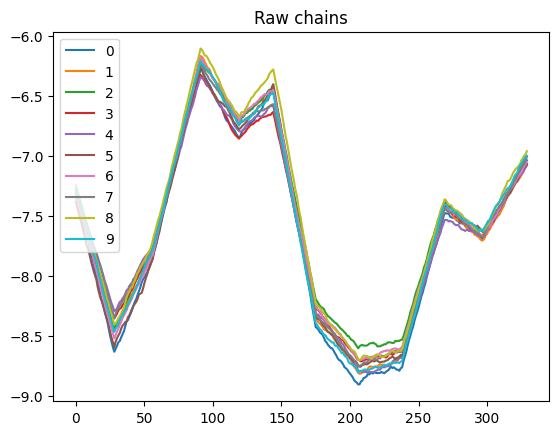

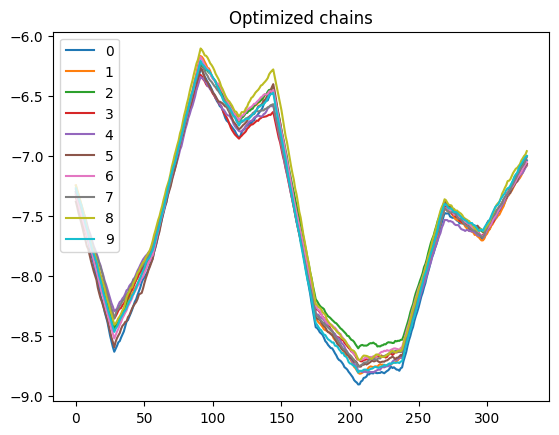

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.313  0.103   0.144    0.495      0.008    0.005     187.0     339.0   
eps    0.713  0.439   0.123    1.496      0.007    0.005    3540.0   10998.0   
p_out  0.234  0.139   0.015    0.489      0.002    0.001    6601.0    9200.0   

       r_hat  
sig     1.03  
eps     1.00  
p_out   1.00  


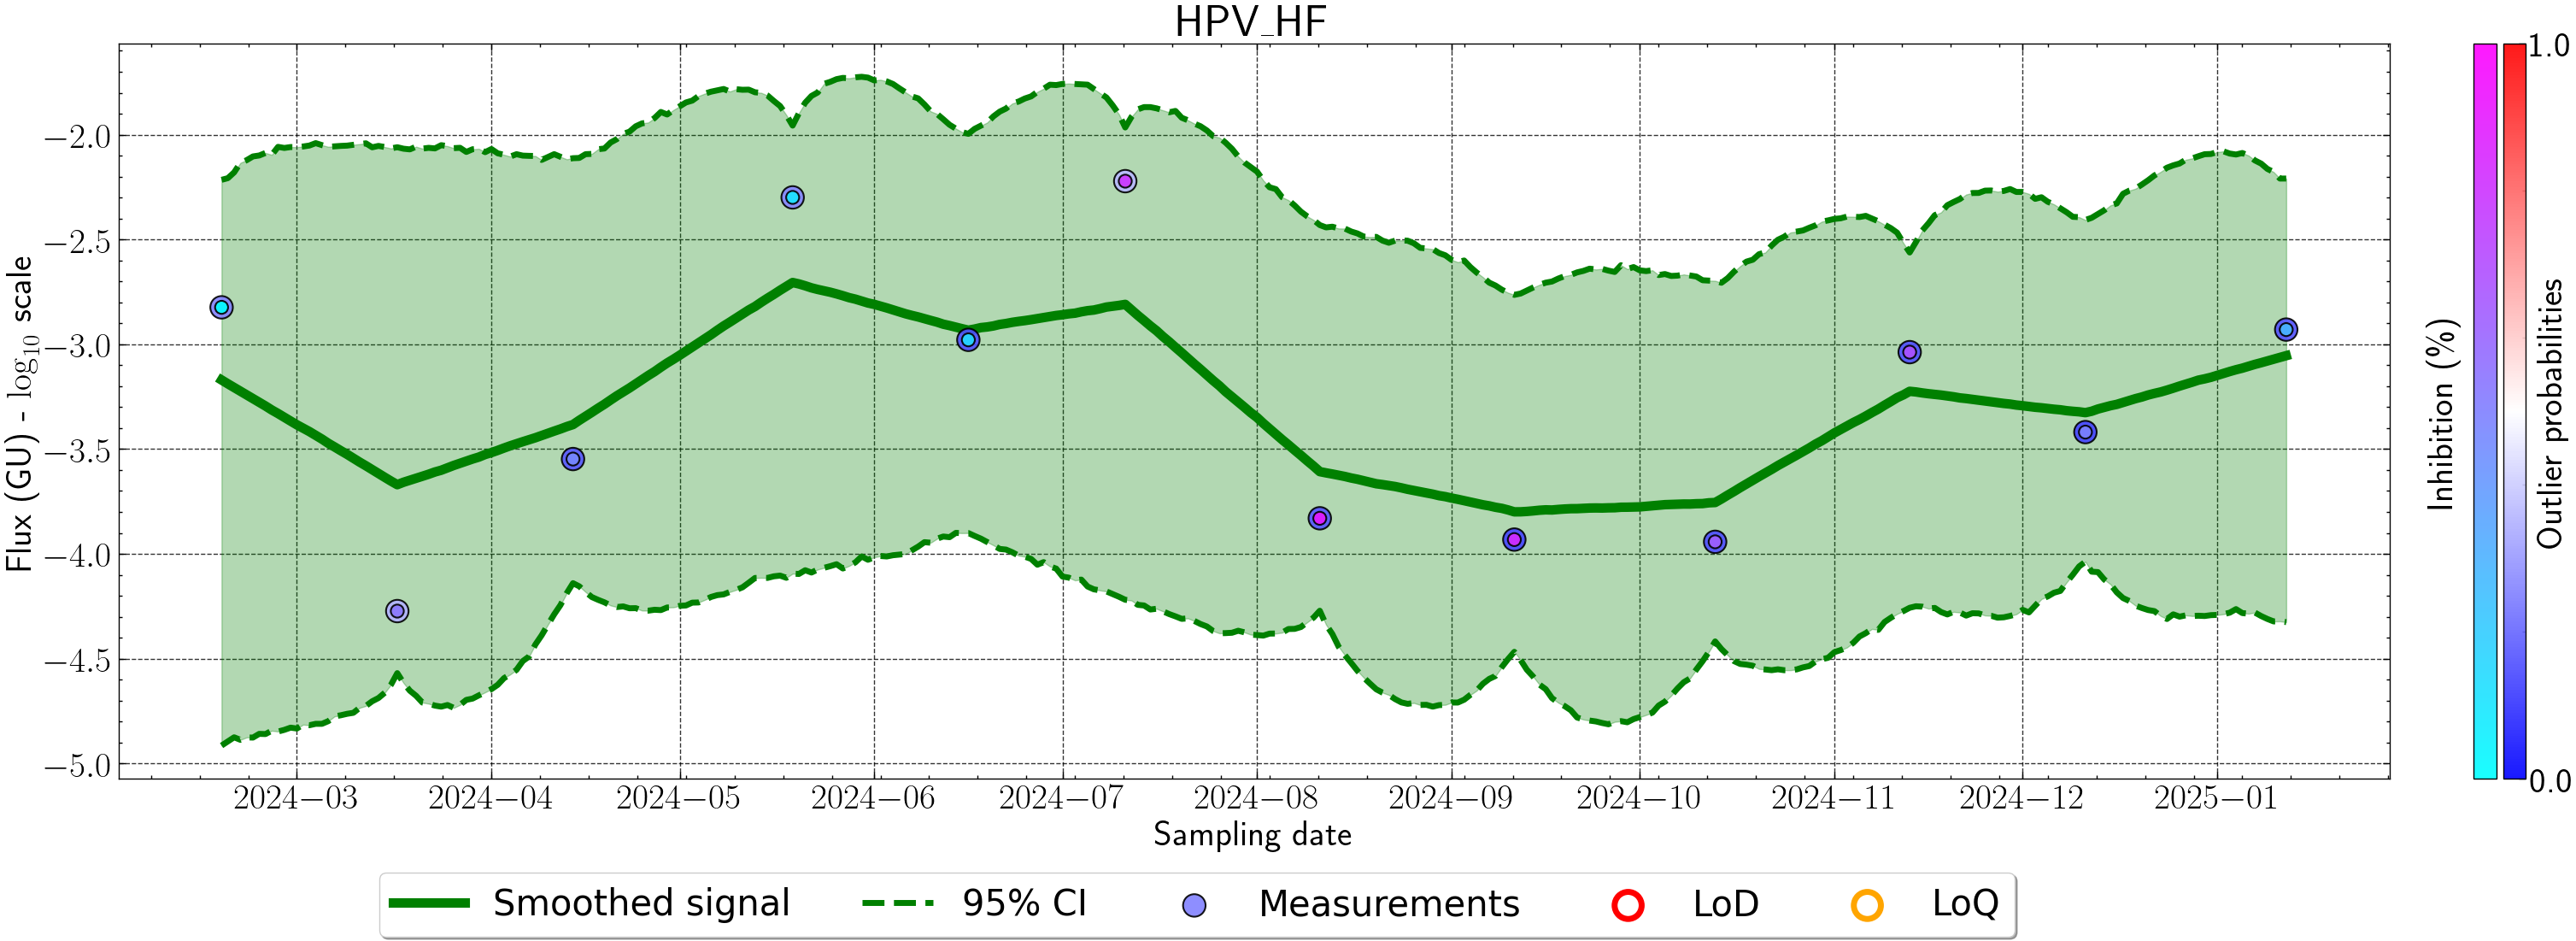

2024-2 [3, 4, 5, 6, 7, 8, 9]
2024-3 [10, 11, 12, 13, 14, 15, 16, 17]
2024-4 [18, 19, 20, 21, 22, 23, 24, 25]
2024-5 [26, 27, 28, 29, 30, 31, 32]
2024-6 [33, 34, 35, 36, 37, 38, 39, 40]
2024-7 [41, 42, 43, 44, 45, 46, 47, 48]
2024-8 [49, 50, 51, 52, 53, 54, 55]
2024-9 [56, 57, 58, 59, 60, 61, 62, 63, 64]
2024-10 [65, 66, 67, 68, 69, 70, 71, 72, 73]
2024-11 [74, 75, 76, 77, 78, 79, 80, 81]
2024-12 [82, 83, 84, 85, 86, 87, 88, 89, 90]
2025-1 [91, 92, 93, 94, 95, 96, 97, 98, 99]
(12, 12) [7, 14, 22, 30, 37, 45, 53, 60, 69, 78, 86, 95]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 633 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.249  0.109   0.110    0.458      0.016    0.011      65.0      90.0   
eps    0.570  0.342   0.119    1.183      0.005    0.004    5491.0    3148.0   
p_out  0.236  0.126   0.020    0.462      0.002    0.001    4847.0    2392.0   

       r_hat  
sig     1.12  
eps     1.00  
p_out   1.00  


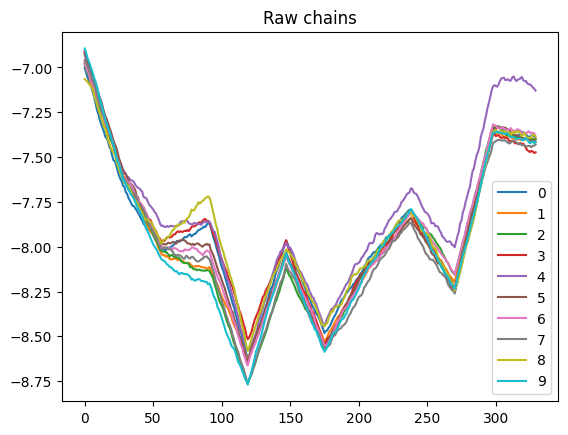

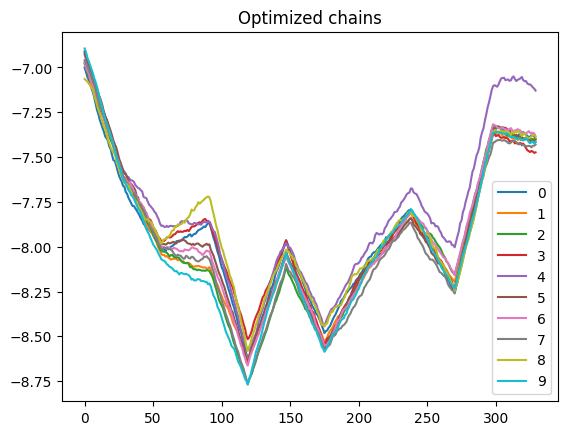

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.249  0.109   0.110    0.458      0.016    0.011      65.0      90.0   
eps    0.570  0.342   0.119    1.183      0.005    0.004    5491.0    3148.0   
p_out  0.236  0.126   0.020    0.462      0.002    0.001    4847.0    2392.0   

       r_hat  
sig     1.12  
eps     1.00  
p_out   1.00  


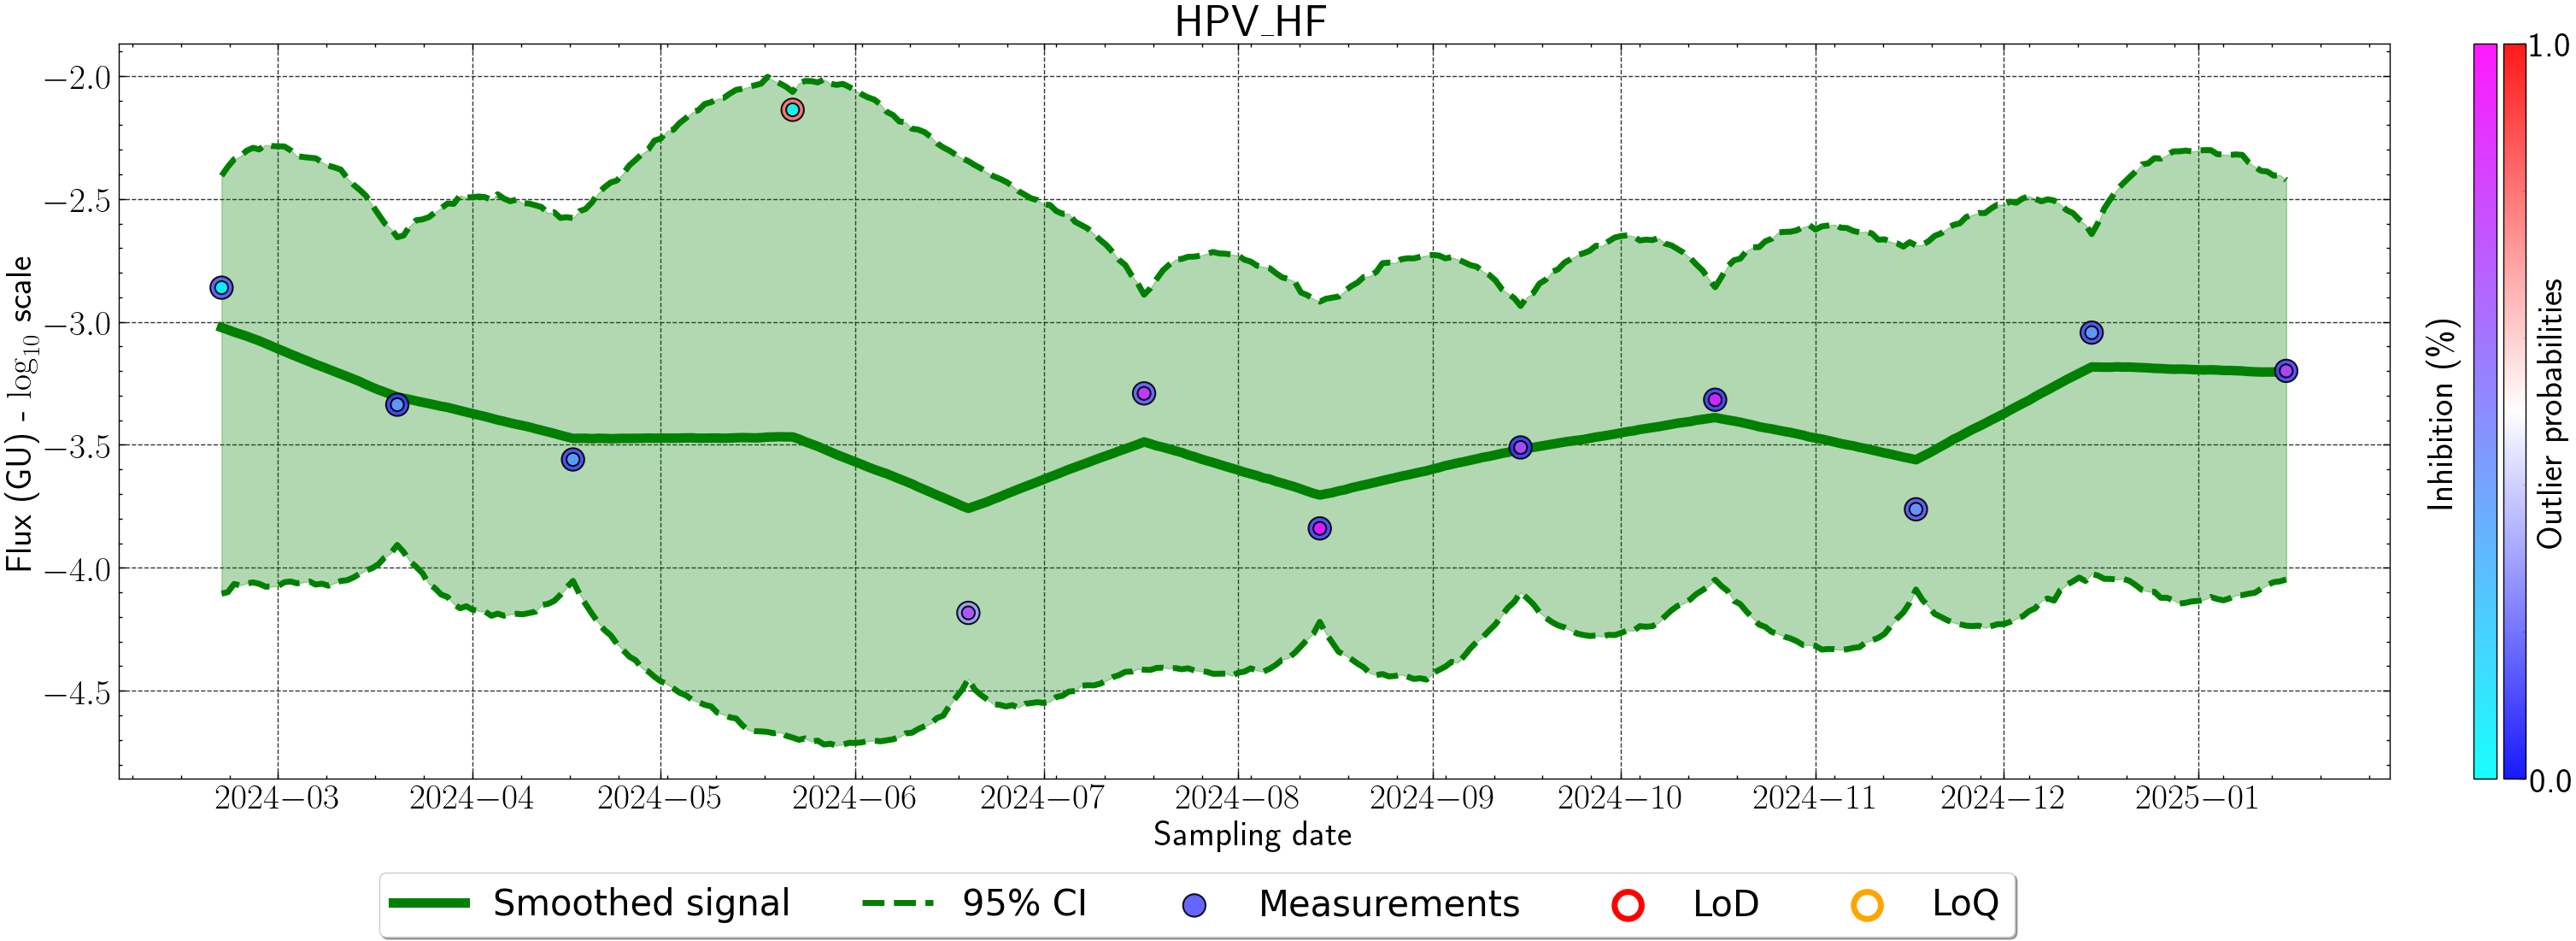

2024-2 [3, 4, 5, 6, 7, 8, 9]
2024-3 [10, 11, 12, 13, 14, 15, 16, 17]
2024-4 [18, 19, 20, 21, 22, 23, 24, 25]
2024-5 [26, 27, 28, 29, 30, 31, 32]
2024-6 [33, 34, 35, 36, 37, 38, 39, 40]
2024-7 [41, 42, 43, 44, 45, 46, 47, 48]
2024-8 [49, 50, 51, 52, 53, 54, 55]
2024-9 [56, 57, 58, 59, 60, 61, 62, 63, 64]
2024-10 [65, 66, 67, 68, 69, 70, 71, 72, 73]
2024-11 [74, 75, 76, 77, 78, 79, 80, 81]
2024-12 [82, 83, 84, 85, 86, 87, 88, 89, 90]
2025-1 [91, 92, 93, 94, 95, 96, 97, 98, 99]
(12, 12) [8, 15, 23, 31, 38, 46, 54, 61, 70, 79, 87, 96]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 738 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.259  0.106   0.111    0.458      0.012    0.009      78.0     200.0   
eps    0.601  0.376   0.119    1.277      0.004    0.003    7502.0   12038.0   
p_out  0.261  0.134   0.034    0.500      0.001    0.001   11280.0   11335.0   

       r_hat  
sig     1.12  
eps     1.00  
p_out   1.00  


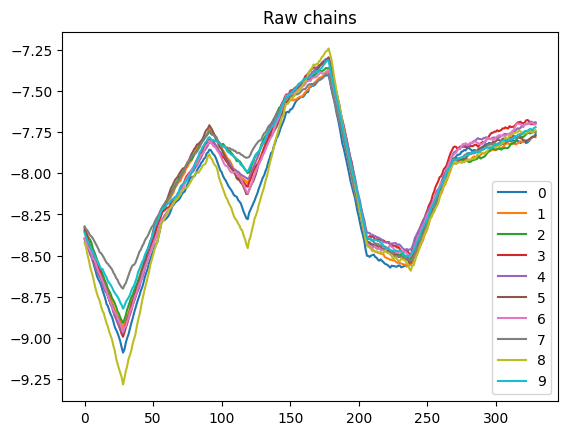

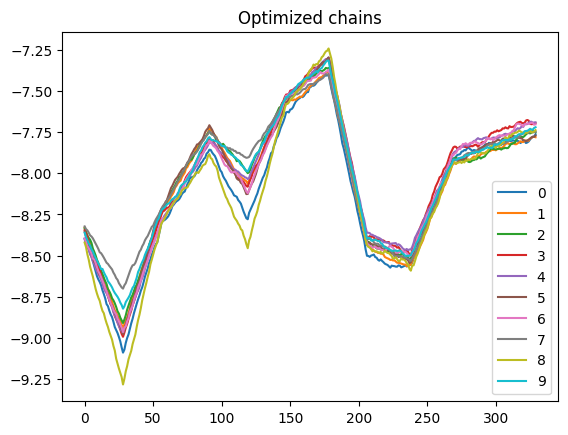

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.259  0.106   0.111    0.458      0.012    0.009      78.0     200.0   
eps    0.601  0.376   0.119    1.277      0.004    0.003    7502.0   12038.0   
p_out  0.261  0.134   0.034    0.500      0.001    0.001   11280.0   11335.0   

       r_hat  
sig     1.12  
eps     1.00  
p_out   1.00  


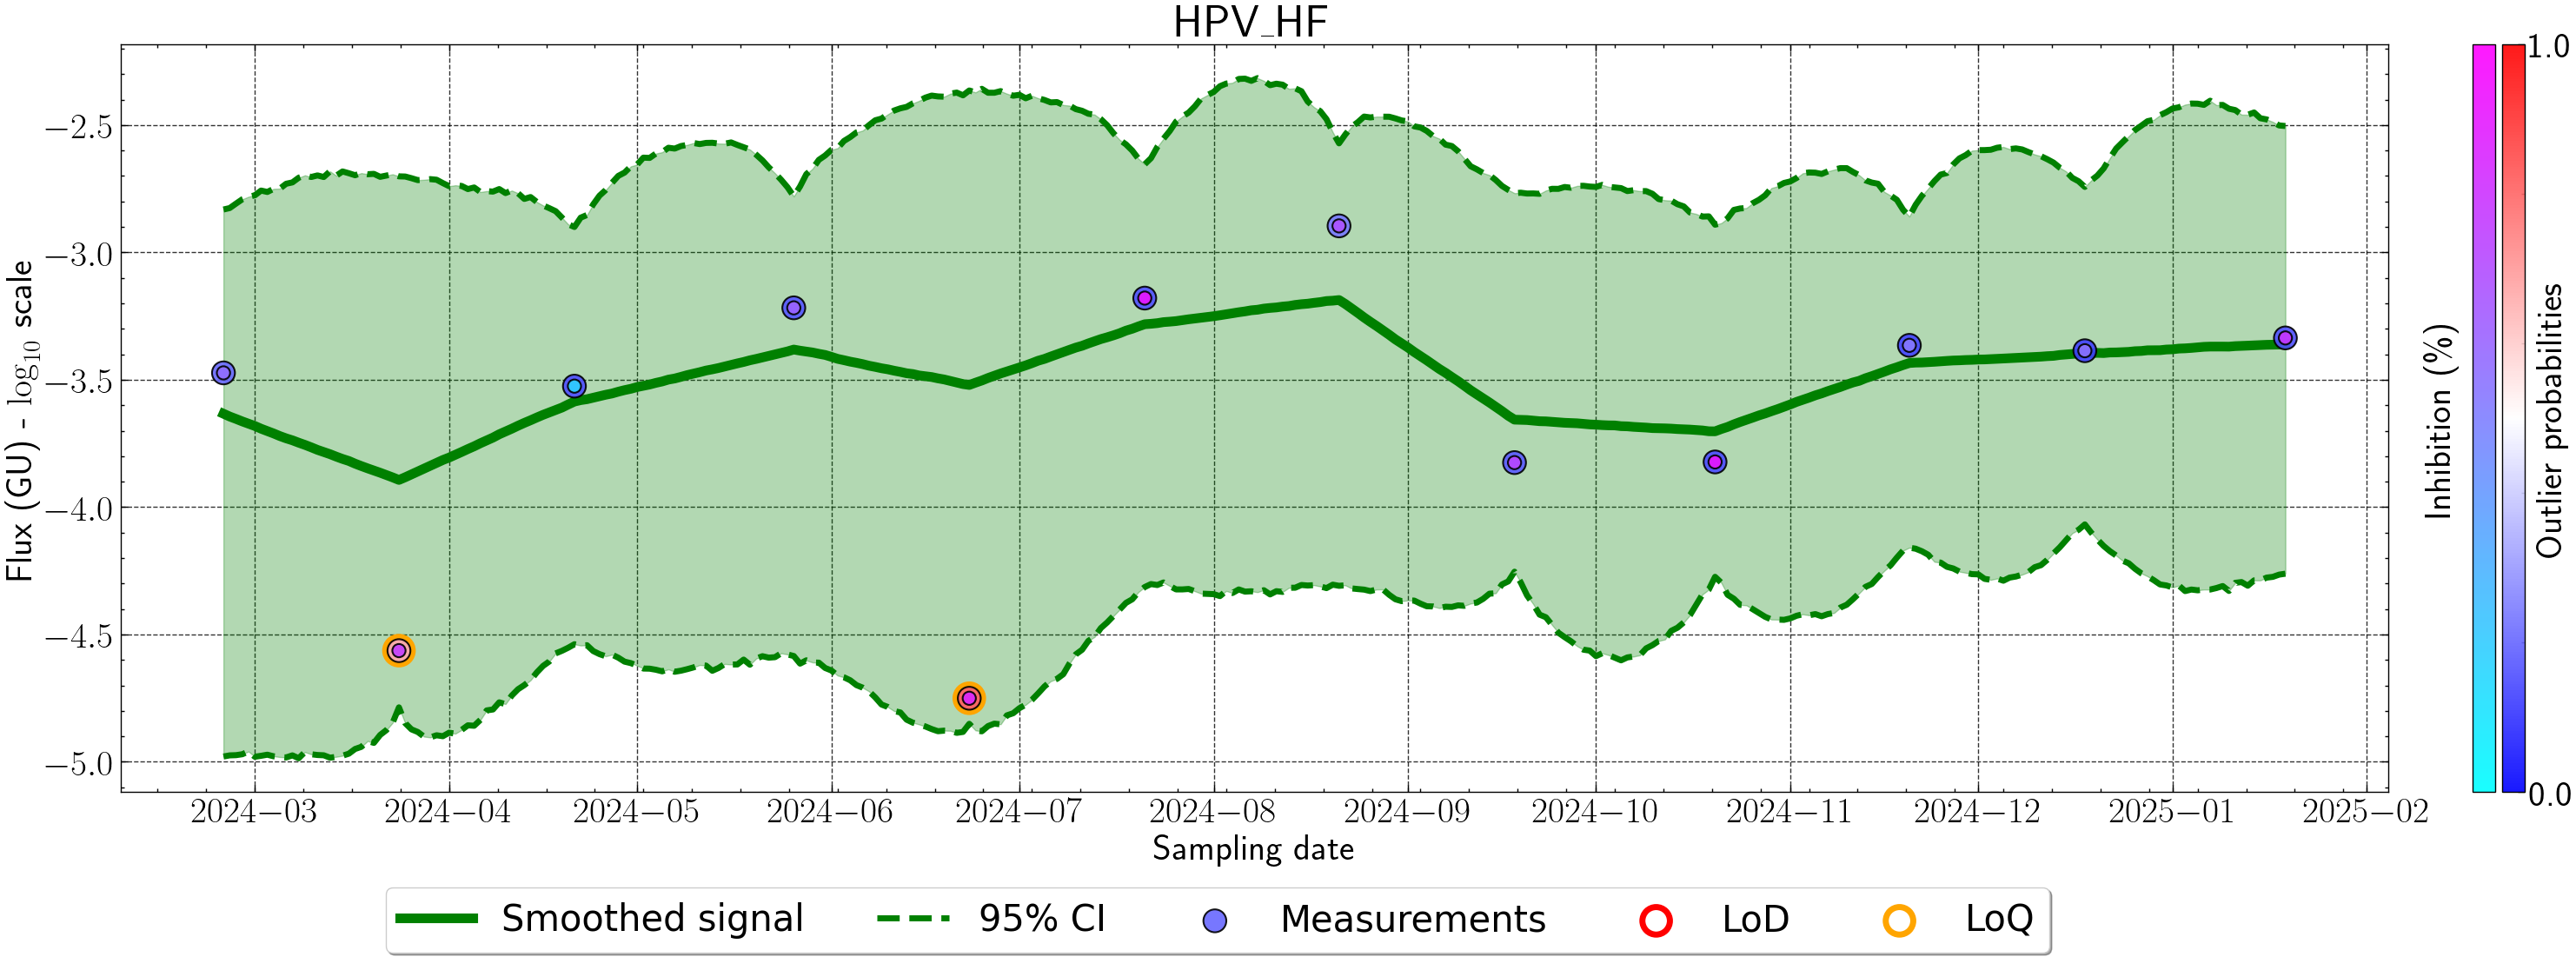

2024-2 [3, 4, 5, 6, 7, 8, 9]
2024-3 [10, 11, 12, 13, 14, 15, 16, 17]
2024-4 [18, 19, 20, 21, 22, 23, 24, 25]
2024-5 [26, 27, 28, 29, 30, 31, 32]
2024-6 [33, 34, 35, 36, 37, 38, 39, 40]
2024-7 [41, 42, 43, 44, 45, 46, 47, 48]
2024-8 [49, 50, 51, 52, 53, 54, 55]
2024-9 [56, 57, 58, 59, 60, 61, 62, 63, 64]
2024-10 [65, 66, 67, 68, 69, 70, 71, 72, 73]
2024-11 [74, 75, 76, 77, 78, 79, 80, 81]
2024-12 [82, 83, 84, 85, 86, 87, 88, 89, 90]
2025-1 [91, 92, 93, 94, 95, 96, 97, 98, 99]
(12, 12) [9, 16, 24, 32, 39, 47, 55, 62, 71, 80, 88, 97]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 708 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.336  0.135   0.122    0.574      0.015    0.010      72.0     121.0   
eps    0.641  0.446   0.116    1.393      0.005    0.003    8978.0   10305.0   
p_out  0.279  0.155   0.020    0.560      0.003    0.002    2539.0    4332.0   

       r_hat  
sig     1.11  
eps     1.00  
p_out   1.01  


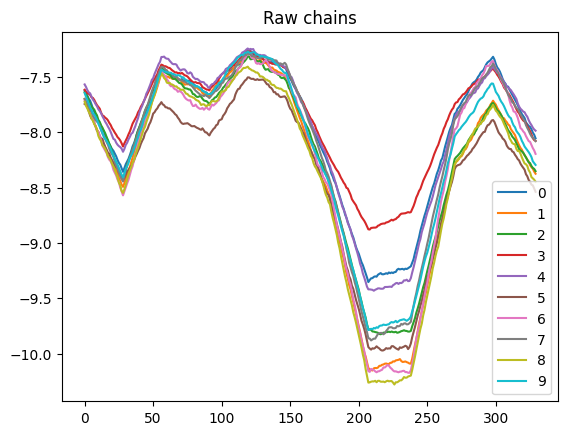

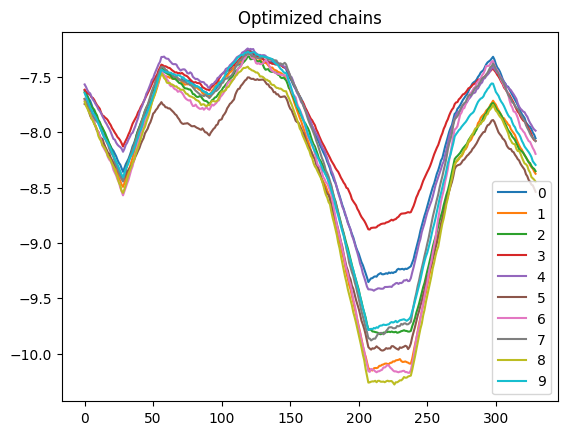

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.336  0.135   0.122    0.574      0.015    0.010      72.0     121.0   
eps    0.641  0.446   0.116    1.393      0.005    0.003    8978.0   10305.0   
p_out  0.279  0.155   0.020    0.560      0.003    0.002    2539.0    4332.0   

       r_hat  
sig     1.11  
eps     1.00  
p_out   1.01  


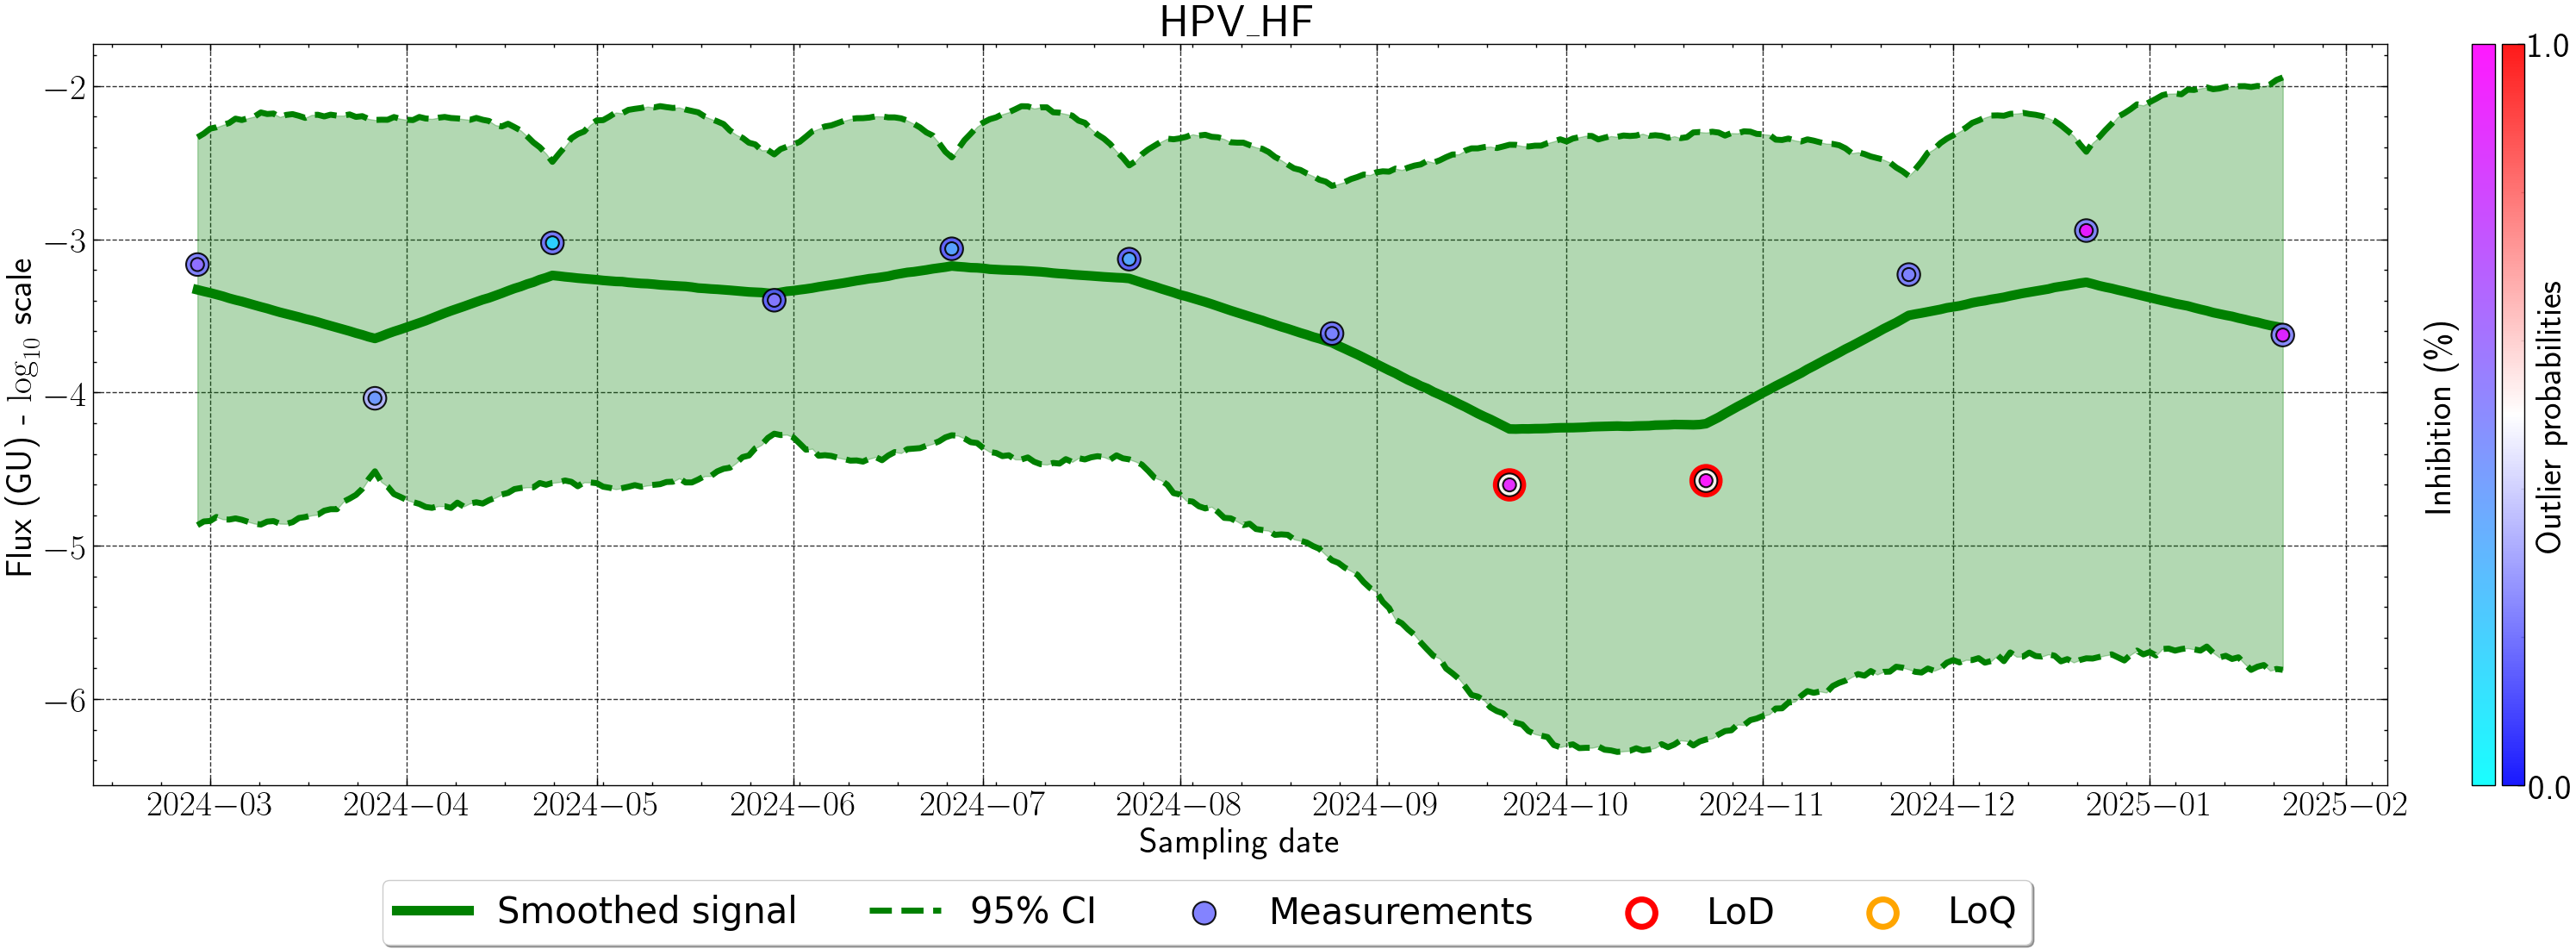

In [22]:
for i in range(7):
    get_monthly_subsamples(data_HPV_HF, index_position=i)

2024-2 [3, 4, 5, 6, 7, 8, 9]
2024-3 [10, 11, 12, 13, 14, 15, 16, 17]
2024-4 [18, 19, 20, 21, 22, 23, 24, 25]
2024-5 [26, 27, 28, 29, 30, 31, 32]
2024-6 [33, 34, 35, 36, 37, 38, 39, 40]
2024-7 [41, 42, 43, 44, 45, 46, 47, 48]
2024-8 [49, 50, 51, 52, 53, 54, 55]
2024-9 [56, 57, 58, 59, 60, 61, 62, 63, 64]
2024-10 [65, 66, 67, 68, 69, 70, 71, 72, 73]
2024-11 [74, 75, 76, 77, 78, 79, 80, 81]
2024-12 [82, 83, 84, 85, 86, 87, 88, 89, 90]
2025-1 [91, 92, 93, 94, 95, 96, 97, 98, 99]
(12, 12) [3, 10, 18, 26, 33, 41, 49, 56, 65, 74, 82, 91]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 904 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.282  0.105   0.117    0.470      0.016    0.012      43.0     109.0   
eps    0.625  0.395   0.131    1.278      0.005    0.003    4848.0    7753.0   
p_out  0.258  0.146   0.019    0.524      0.003    0.002    3077.0    4079.0   

       r_hat  
sig     1.19  
eps     1.00  
p_out   1.01  


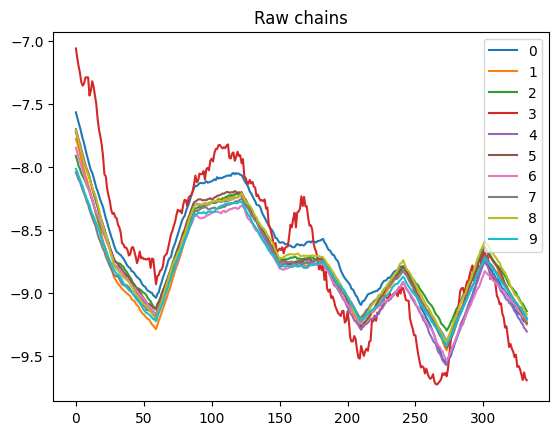

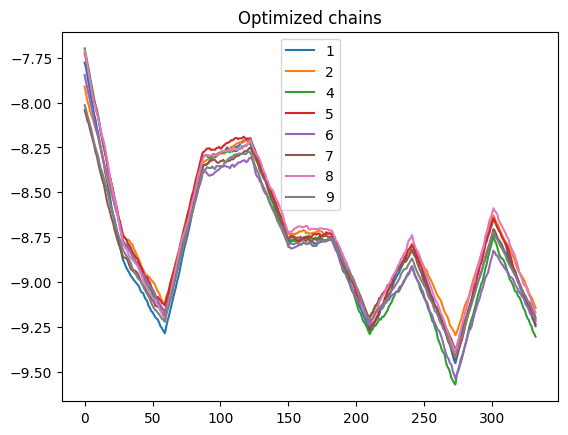

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.265  0.093   0.116    0.436      0.011    0.008      78.0     206.0   
eps    0.623  0.392   0.131    1.276      0.005    0.003    6836.0   11216.0   
p_out  0.257  0.143   0.019    0.513      0.002    0.001    7289.0    9248.0   

       r_hat  
sig     1.09  
eps     1.00  
p_out   1.00  


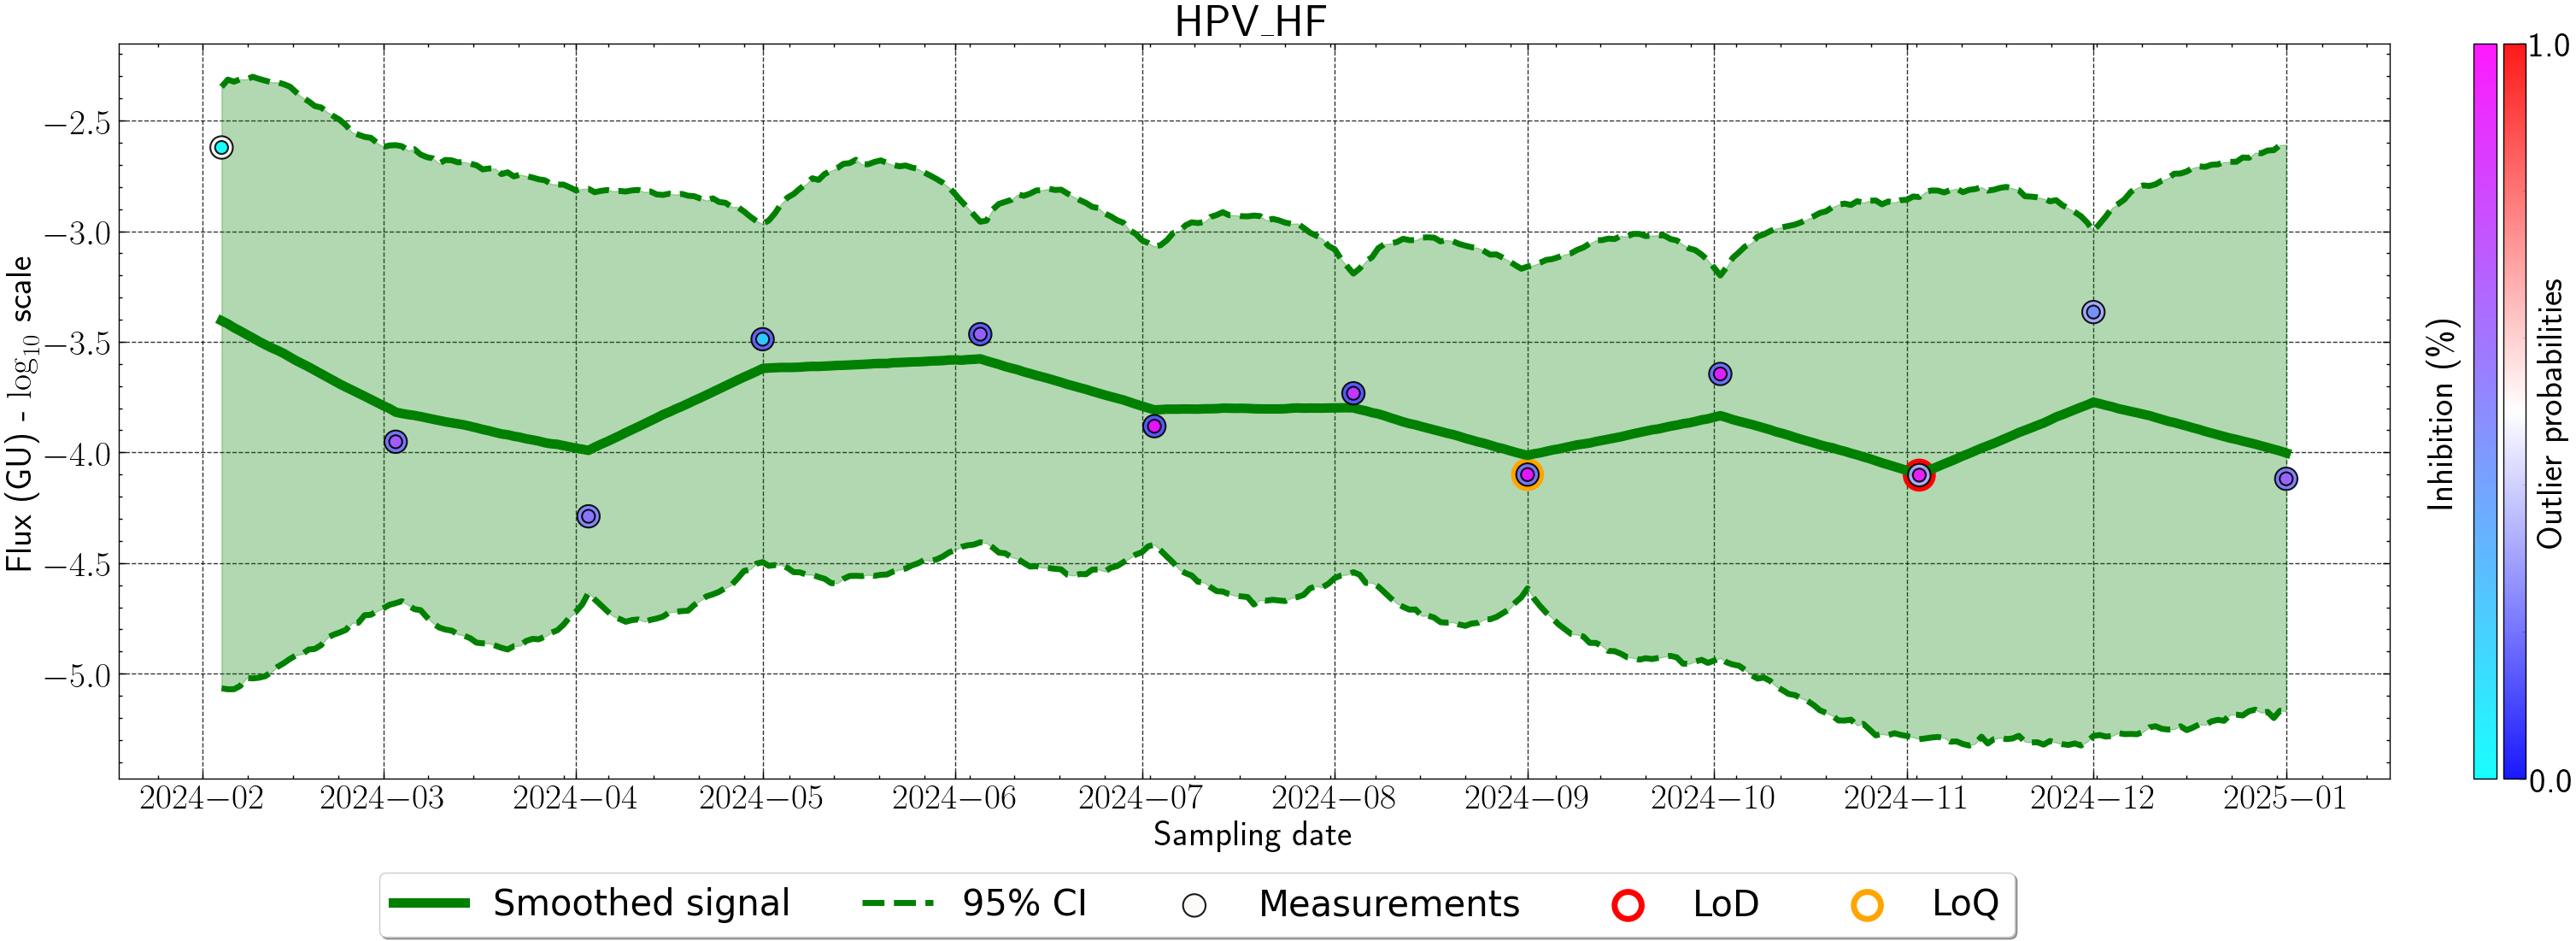

In [23]:
# mixing is not optimal for the first scenario; estimating the parameters once again but getting rid of diverging chains:
for i in [0]:
    get_monthly_subsamples(data_HPV_HF, index_position=i, remove_those=[0, 3])

2024-2 [3, 4, 5, 6, 7, 8, 9]
2024-3 [10, 11, 12, 13, 14, 15, 16, 17]
2024-4 [18, 19, 20, 21, 22, 23, 24, 25]
2024-5 [26, 27, 28, 29, 30, 31, 32]
2024-6 [33, 34, 35, 36, 37, 38, 39, 40]
2024-7 [41, 42, 43, 44, 45, 46, 47, 48]
2024-8 [49, 50, 51, 52, 53, 54, 55]
2024-9 [56, 57, 58, 59, 60, 61, 62, 63, 64]
2024-10 [65, 66, 67, 68, 69, 70, 71, 72, 73]
2024-11 [74, 75, 76, 77, 78, 79, 80, 81]
2024-12 [82, 83, 84, 85, 86, 87, 88, 89, 90]
2025-1 [91, 92, 93, 94, 95, 96, 97, 98, 99]
(12, 12) [5, 12, 20, 28, 35, 43, 51, 58, 67, 76, 84, 93]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 889 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.270  0.110   0.119    0.469      0.013    0.009      54.0     173.0   
eps    0.630  0.377   0.118    1.301      0.004    0.003    7021.0   10430.0   
p_out  0.254  0.139   0.030    0.508      0.010    0.009     461.0      89.0   

       r_hat  
sig     1.14  
eps     1.01  
p_out   1.03  


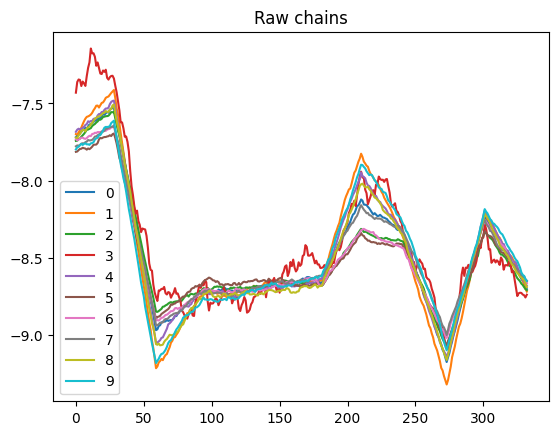

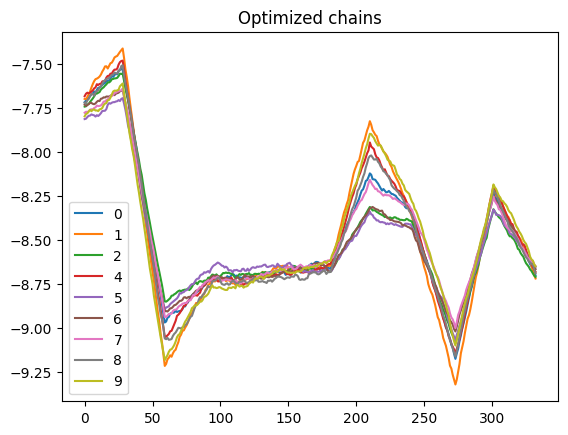

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.270  0.109   0.119    0.469      0.015    0.010      45.0     211.0   
eps    0.630  0.380   0.120    1.310      0.004    0.003    7152.0   10654.0   
p_out  0.245  0.125   0.030    0.470      0.001    0.001    8057.0   10303.0   

       r_hat  
sig     1.15  
eps     1.00  
p_out   1.00  


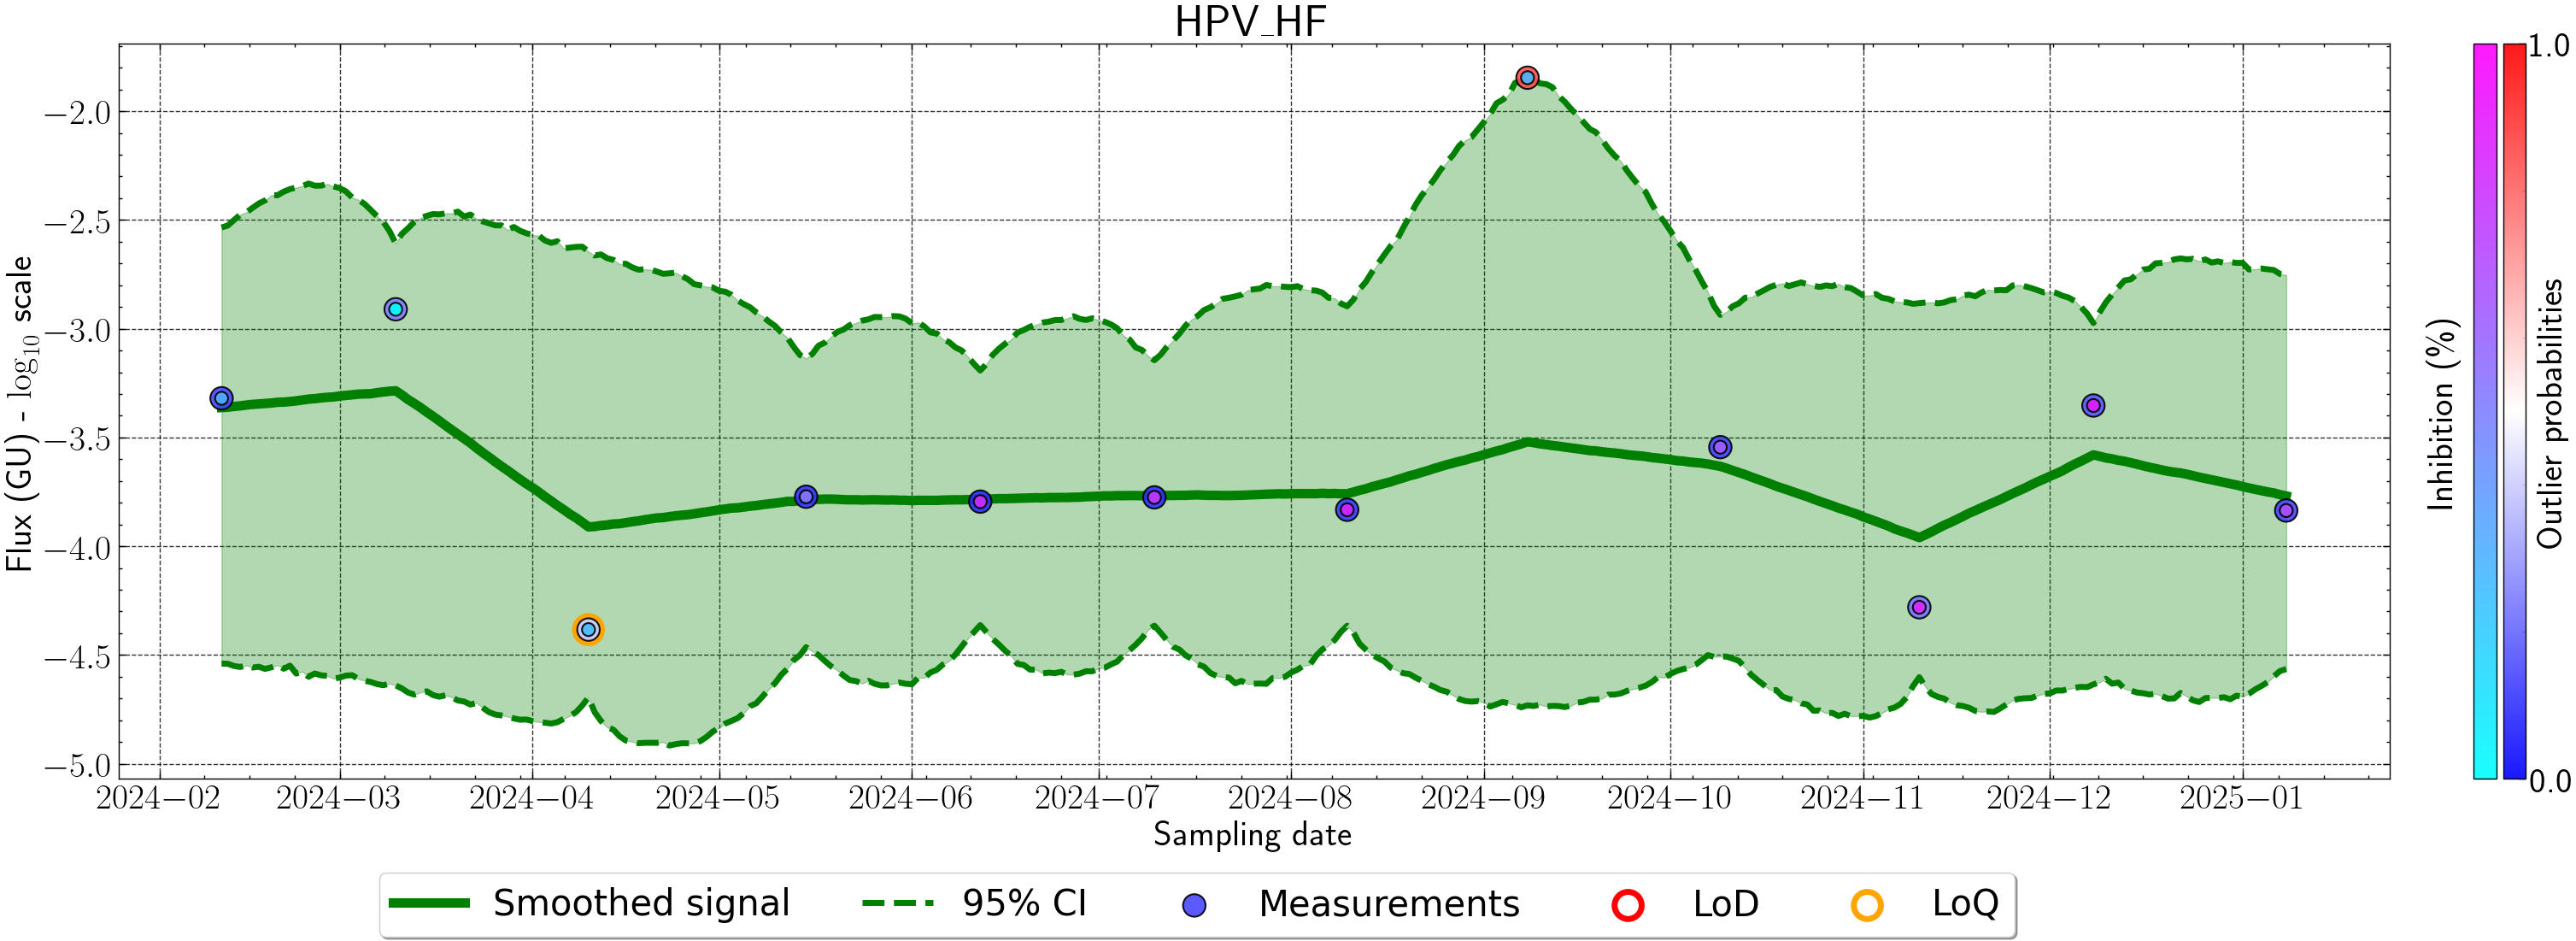

In [24]:
for i in [2]:
    get_monthly_subsamples(data_HPV_HF, index_position=i, remove_those=[3])

2024-2 [3, 4, 5, 6, 7, 8, 9]
2024-3 [10, 11, 12, 13, 14, 15, 16, 17]
2024-4 [18, 19, 20, 21, 22, 23, 24, 25]
2024-5 [26, 27, 28, 29, 30, 31, 32]
2024-6 [33, 34, 35, 36, 37, 38, 39, 40]
2024-7 [41, 42, 43, 44, 45, 46, 47, 48]
2024-8 [49, 50, 51, 52, 53, 54, 55]
2024-9 [56, 57, 58, 59, 60, 61, 62, 63, 64]
2024-10 [65, 66, 67, 68, 69, 70, 71, 72, 73]
2024-11 [74, 75, 76, 77, 78, 79, 80, 81]
2024-12 [82, 83, 84, 85, 86, 87, 88, 89, 90]
2025-1 [91, 92, 93, 94, 95, 96, 97, 98, 99]
(12, 12) [7, 14, 22, 30, 37, 45, 53, 60, 69, 78, 86, 95]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 677 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.249  0.109   0.110    0.458      0.016    0.011      65.0      90.0   
eps    0.570  0.342   0.119    1.183      0.005    0.004    5491.0    3148.0   
p_out  0.236  0.126   0.020    0.462      0.002    0.001    4847.0    2392.0   

       r_hat  
sig     1.12  
eps     1.00  
p_out   1.00  


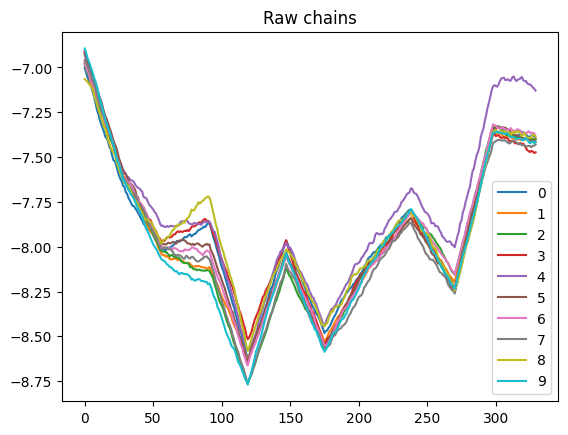

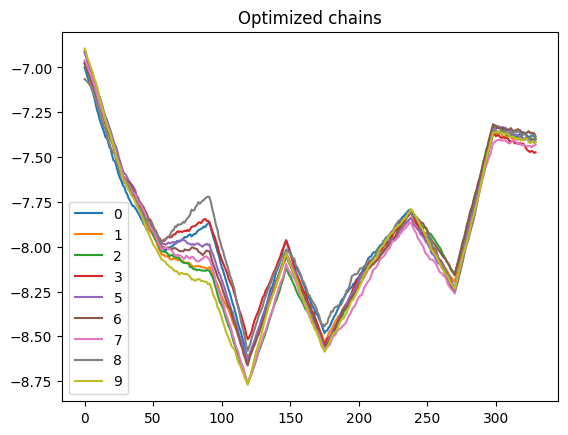

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.244  0.097   0.110    0.430      0.012    0.009      76.0     133.0   
eps    0.566  0.334   0.128    1.178      0.005    0.004    4828.0    2904.0   
p_out  0.234  0.124   0.026    0.462      0.001    0.001    6149.0    1932.0   

       r_hat  
sig      1.1  
eps      1.0  
p_out    1.0  


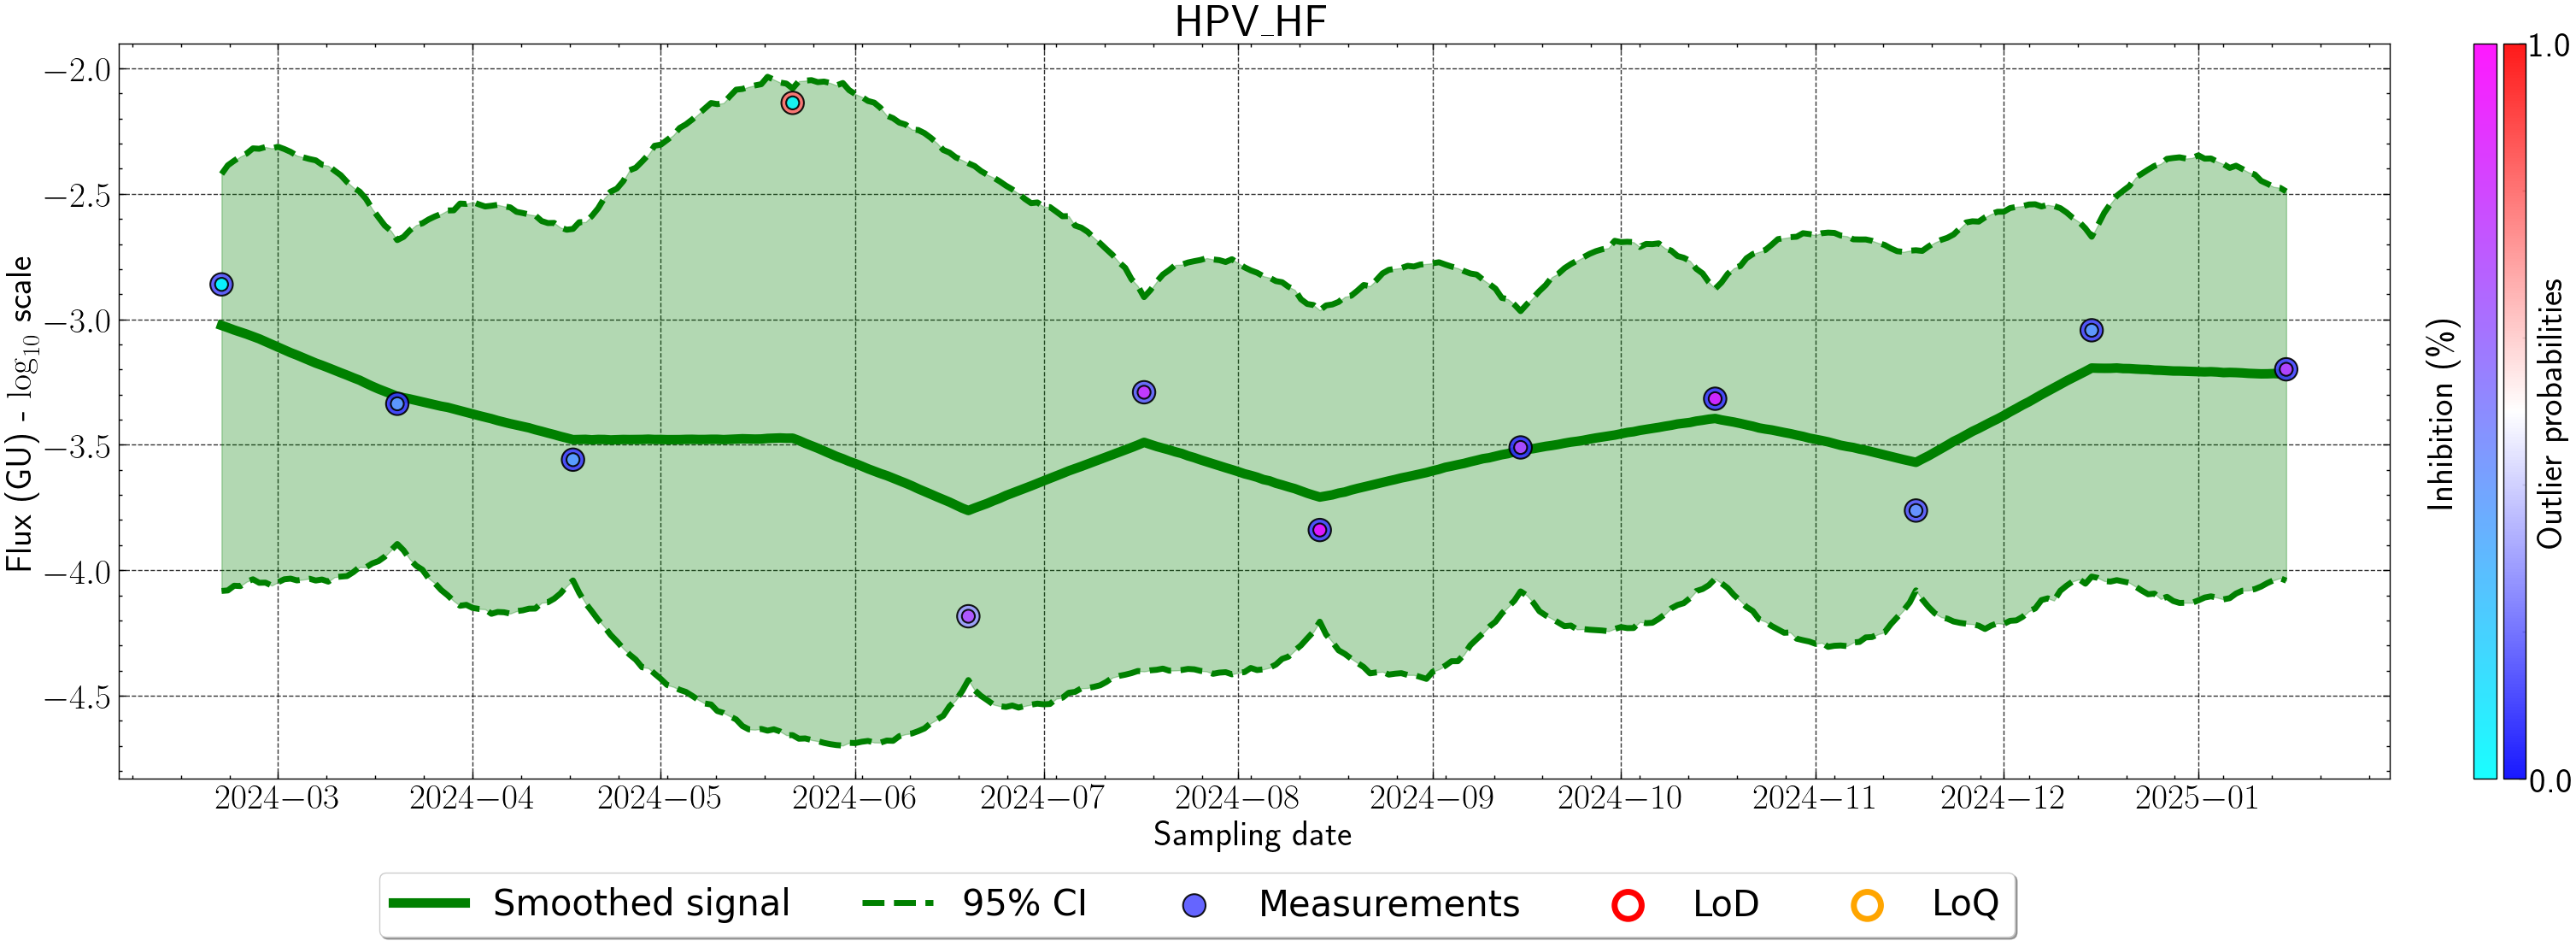

In [25]:
for i in [4]:
    get_monthly_subsamples(data_HPV_HF, index_position=i, remove_those=[4])

2024-2 [3, 4, 5, 6, 7, 8, 9]
2024-3 [10, 11, 12, 13, 14, 15, 16, 17]
2024-4 [18, 19, 20, 21, 22, 23, 24, 25]
2024-5 [26, 27, 28, 29, 30, 31, 32]
2024-6 [33, 34, 35, 36, 37, 38, 39, 40]
2024-7 [41, 42, 43, 44, 45, 46, 47, 48]
2024-8 [49, 50, 51, 52, 53, 54, 55]
2024-9 [56, 57, 58, 59, 60, 61, 62, 63, 64]
2024-10 [65, 66, 67, 68, 69, 70, 71, 72, 73]
2024-11 [74, 75, 76, 77, 78, 79, 80, 81]
2024-12 [82, 83, 84, 85, 86, 87, 88, 89, 90]
2025-1 [91, 92, 93, 94, 95, 96, 97, 98, 99]
(12, 12) [9, 16, 24, 32, 39, 47, 55, 62, 71, 80, 88, 97]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 685 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.336  0.135   0.122    0.574      0.015    0.010      72.0     121.0   
eps    0.641  0.446   0.116    1.393      0.005    0.003    8978.0   10305.0   
p_out  0.279  0.155   0.020    0.560      0.003    0.002    2539.0    4332.0   

       r_hat  
sig     1.11  
eps     1.00  
p_out   1.01  


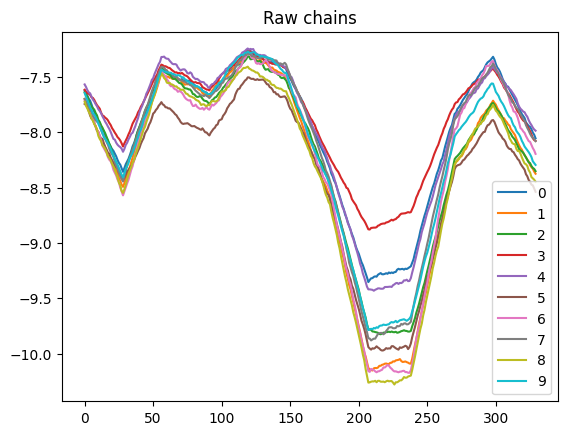

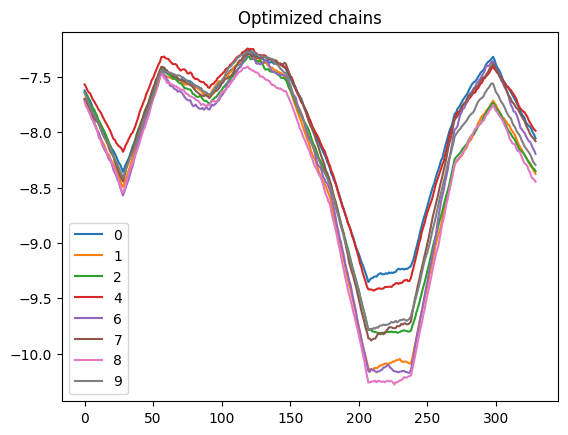

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.341  0.123   0.117    0.562      0.013    0.009      81.0      68.0   
eps    0.635  0.436   0.117    1.375      0.005    0.004    7588.0    8620.0   
p_out  0.274  0.153   0.018    0.553      0.003    0.002    2919.0    5066.0   

       r_hat  
sig     1.09  
eps     1.00  
p_out   1.00  


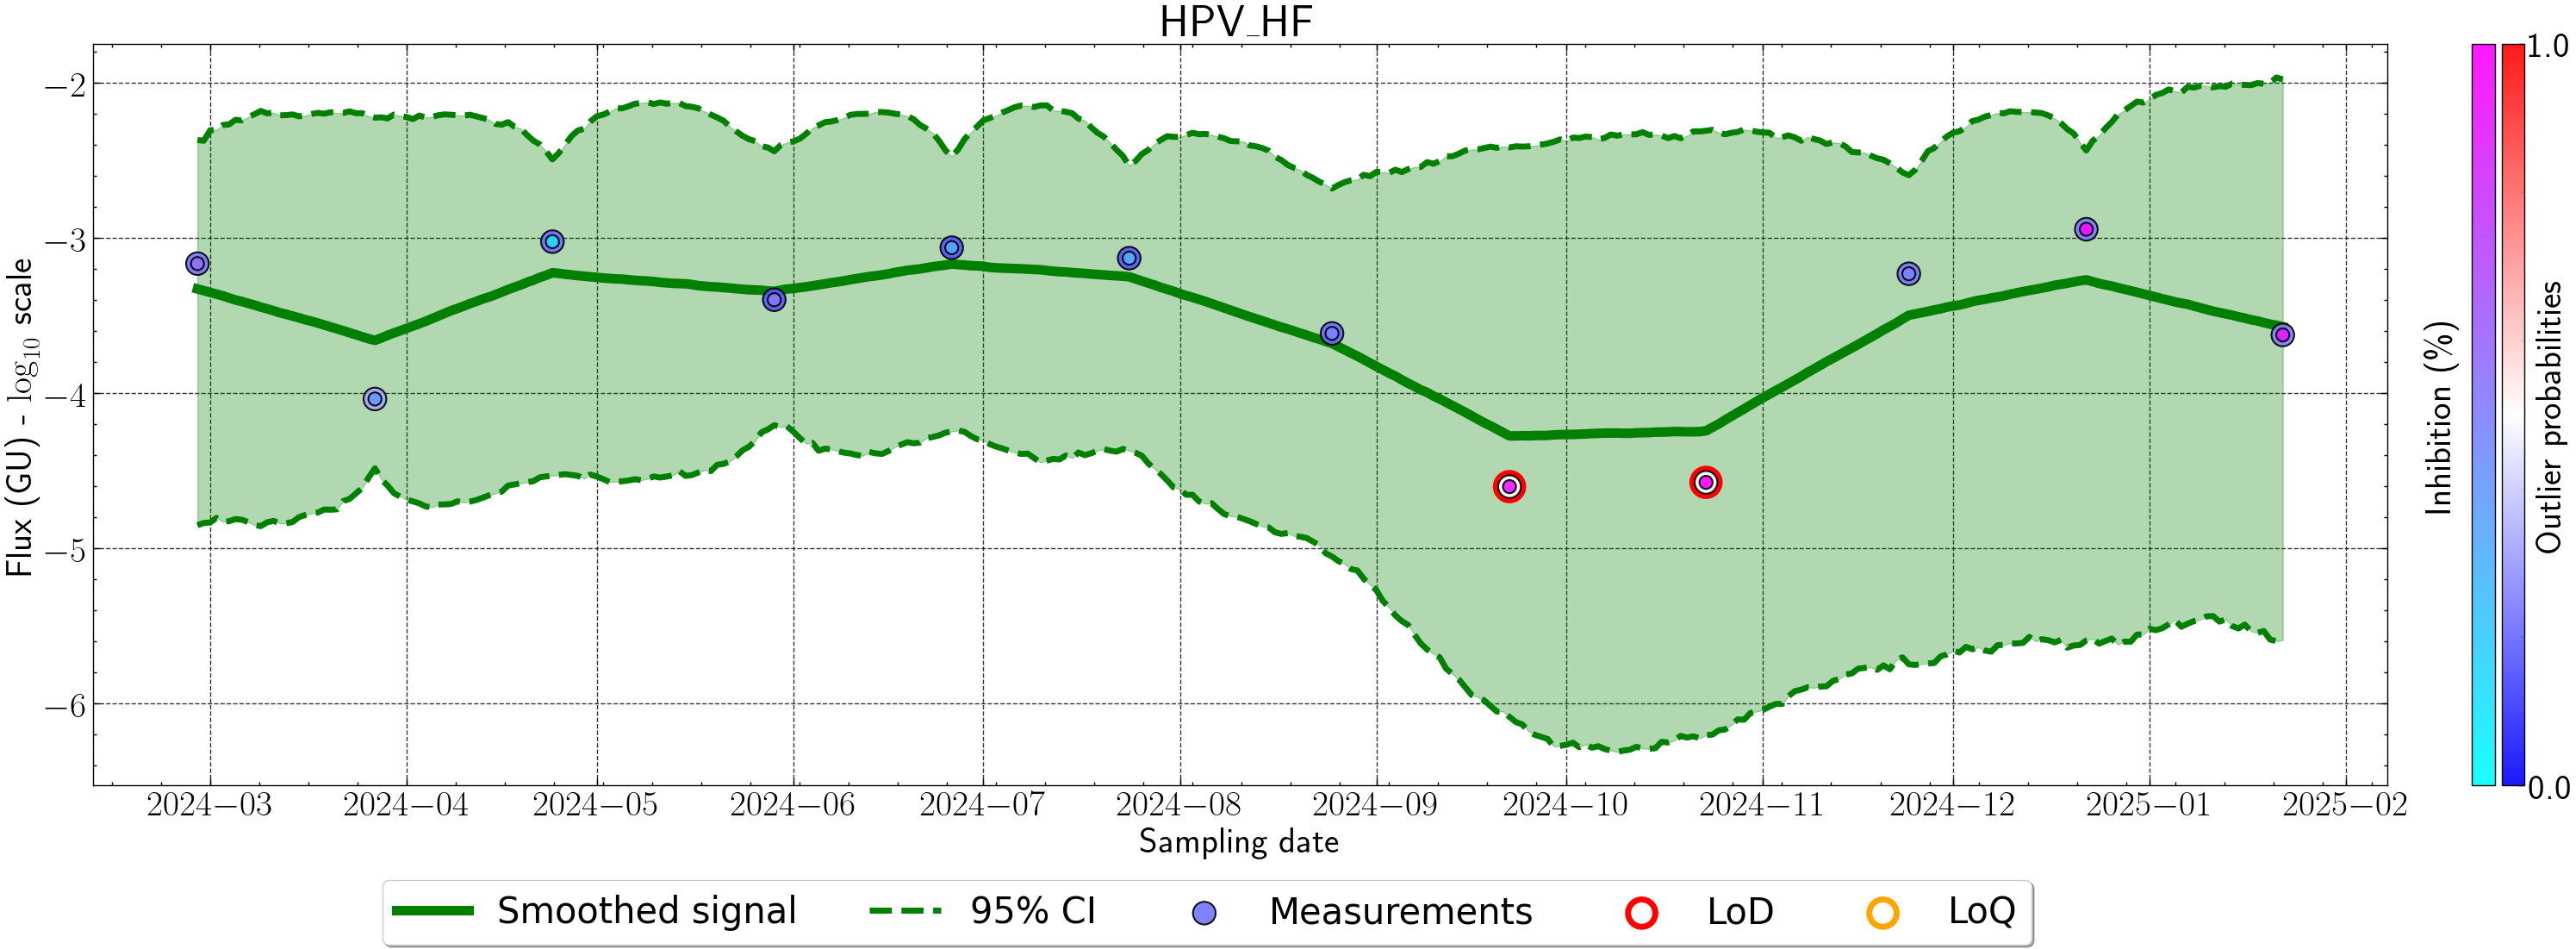

In [26]:
for i in [6]:
    get_monthly_subsamples(data_HPV_HF, index_position=i, remove_those=[3, 5])